In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
import jax.lax as lax
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

In [2]:
# Enable float64 precision
jax.config.update("jax_enable_x64", True)

# Lecture Notes: Two Computations to Fund Social Security

## 1. Introduction

This paper by Huang, Imrohoroglu, and Sargent addresses a critical research question: How can we design a transition from an unfunded to a funded social security system that is both economically efficient and politically feasible?

The importance of this research cannot be overstated. As many developed economies face aging populations, pay-as-you-go social security systems become increasingly unsustainable. However, any transition to a fully funded system creates substantial distributional challenges, as older generations who contributed to the unfunded system would potentially lose benefits without compensation.

A distinctive methodological aspect of this paper is its use of a linear-quadratic (LQ) framework, which allows for analytical tractability while incorporating meaningful economic complexity. By employing the risk-sensitive, linear-quadratic formulation of Hansen and Sargent (1995), the model can handle environments where social security serves as a device for insuring against risky incomes and lifetimes. This approach yields linear decision rules for individual consumption and savings, making it computationally feasible to track the distribution of consumption and wealth across cohorts. However, this computational convenience comes with limitations—particularly the assumption of quadratic preferences and Gaussian shocks, which may not fully capture the non-linearities and asymmetries present in actual economic decision-making under uncertainty.

Let's examine a general equilibrium overlapping generations model with a larger state space than previous literature. This approach extends the Auerbach and Kotlikoff (1987) methodology by incorporating:

1. Risk-sensitive preferences
2. Uncertainty about lifetimes 
3. Uninsurable labor income risk
4. A theory of consumption distribution within and across cohorts

This framework allows us to study how alternative transitions between fiscal policies and social security arrangements affect income and wealth distributions both within and across generations.

## 2. Model Settings

### 2.1 Environment and Basics

The economy consists of overlapping generations of finitely lived individuals who may live up to $T_0+1$ years and an infinitely lived government. Both individuals and the government can invest at a constant risk-free gross rate of return.

During the first $T_1+1$ periods, consumers receive labor income, which they divide between consumption, taxes, and asset accumulation. During the final $T_0-T_1$ periods (retirement), consumers receive social security benefits and consume their accumulated assets.

The government taxes income from capital and labor, issues debt, purchases goods, and pays retirement benefits.

For any variable $z$, let's use:
- Subscript $t$ to denote age
- Argument $s$ in parentheses to denote calendar time
- Superscript $s-t$ to denote date of birth

Thus: $z^{s-t}(s) \equiv z_t(s) \equiv z^{s-t}_t(s)$

### 2.2 Demographics

At date $s$, a cohort of measure $N_0(s)$ consumers is born who live during periods $s, s+1, ..., s+T_0$. As a cohort ages, its members face random survival according to age-to-age survival probabilities $\{\alpha_t\}^{T_0}_{t=0}$, where $\alpha_t$ is the probability of surviving from age $t$ to $t+1$.

Let $N_t(s)$ be the number of age $t$ people alive at time $s$ and $n$ be the constant gross rate of population growth. We have:

$$N_t(s) = \lambda_t \cdot N_0(s-t)$$

where $\lambda_t = \prod^{t-1}_{j=0} \alpha_j$ for $t = 0,...T_0$, and $\lambda_0 = 1$.

Births follow: $N_0(s) = n^s \cdot N_0(0)$

The population fraction of cohort $t$ at each time $s$ is:

$$f_t = \frac{\lambda_t \cdot n^{-t}}{\sum^{T_0}_{\tau=0} \lambda_\tau \cdot n^{-\tau}}$$

The total population at time $s$ is:

$$N(s) = N_0(0) \cdot n^s \cdot \sum^{T_0}_{t=0} n^{-t} \cdot \lambda_t$$

### 2.3 Distributions and Aggregates

Individuals face life span uncertainty and labor income shocks, which they cannot fully insure. They self-insure by accumulating risk-free assets (government bonds and physical capital) and combining these with social security benefits.

Let $\epsilon^t_0$ denote the history of random shocks an individual has received from birth to age $t$.

The state vector $x_t(s) = x_t(s; \epsilon^t_0, x_0)$ measures the stock of assets and variables a consumer uses to forecast future preferences or opportunities.

The model delivers consumption as a time- and age-dependent linear function of the state vector:

$$c_t(s; \epsilon^t_0, x_0) = \eta_{ct}(s) \cdot x_t(s; \epsilon^t_0, x_0)$$

The state vector follows a linear law of motion:

$$x_{t+1}(s+1; \epsilon^{t+1}_0, x_0) = A_t(s) \cdot x_t(s; \epsilon^t_0, x_0) + C_t(s) \cdot \epsilon_{t+1}$$

where $\epsilon_{t+1}$ is a martingale difference sequence with $E(\epsilon_{t+1}|J_t) = 0$, $E(\epsilon_{t+1} \cdot \epsilon'_{t+1}|J_t) = I$, and $J_t = (\epsilon^t_0, x_0)$.

Given rational expectations, the model delivers probability distributions for state vectors and linear functions of them. Let $\mu_t(s) = E[x_t(s)]$ and $\Sigma_t(s) = E[(x_t(s)-\mu_t(s))(x_t(s)-\mu_t(s))']$.

These moments follow:

$$\mu_{t+1}(s+1) = A_t(s) \cdot \mu_t(s)$$
$$\Sigma_{t+1}(s+1) = A_t(s) \cdot \Sigma_t(s) \cdot A_t(s)' + C_t(s) \cdot C_t(s)'$$

Per capita aggregate consumption is:

$$c(s)/N(s) = \sum^{T_0}_{t=0} \mu_{ct}(s) \cdot f_t$$

where $\mu_{ct}(s)$ is the mean consumption of age-$t$ people at time $s$.

The distribution of consumption within age cohort $t$ has mean and variance:
- $\mu_{ct}(s) = \eta_{ct}(s) \cdot \mu_t(s)$
- $\Sigma_{ct}(s) = \eta_{ct}(s) \cdot \Sigma_t(s) \cdot \eta_{ct}(s)'$

### 2.4 Resource Constraint

The economy-wide physical resource constraint is:

$$g(s) \cdot N(s) + \sum^{T_0}_{t=0} c_t(s) \cdot N^{s-t}_t + K(s) = R(s-1) \cdot K(s-1) + w(s) \cdot \sum^{T_1}_{t=0} \varepsilon_t \cdot N^{s-t}_t + N_0(s) \cdot k_{-1}(s)$$

where:
- $g(s)$ is per capita government purchases
- $K(s-1)$ is physical capital
- $R(s-1) = 1 + r(s-1) - \delta$ is the gross return on assets
- $\varepsilon_t$ is the exogenous efficiency endowment of age-$t$ people
- $w(s)$ is the base wage rate
- $N_0(s) \cdot k_{-1}(s)$ is capital brought by newborns
- $\delta$ is the depreciation rate

### 2.5 Factor Prices

Let's consider two alternative assumptions about factor prices:

1. Small open economy: $r(s-1) = r$ and $w(s) = w$ are exogenous and constant

2. Closed economy: Factor prices determined by marginal products in a Cobb-Douglas production function
  - $r(s-1) = r(K(s-1)/\tilde{N}(s)) = \tilde{A} \cdot \tilde{\alpha} \cdot (K(s-1)/\tilde{N}(s))^{\tilde{\alpha}-1}$
  - $w(s) = w(K(s-1)/\tilde{N}(s)) = (1-\tilde{\alpha}) \cdot A \cdot (K(s-1)/\tilde{N}(s))^{\tilde{\alpha}}$

where $\tilde{N}(s) = \sum^{T_1}_{t=0} \varepsilon_t \cdot N^{s-t}_t$ is aggregate labor input in efficiency units, and $\tilde{\alpha}$ is capital's share of income.

### 2.6 Household Problem

Households face a permanent income model with restricted assets. Working-age consumers ($t \leq T_1$) receive labor income $w(s) \cdot \varepsilon_t + d_t$, where $d_t$ is an AR(1) process:

$$d_t = \rho_d \cdot d_{t-1} + \xi_t$$

where $\xi_t$ is Gaussian white noise with variance $\sigma^2_d$.

The budget constraint at age $t$ and time $s$ is:

$$c_t(s) + a_t(s) = R(s-1) \cdot a_{t-1}(s-1) + w(s) \cdot \varepsilon_t + S_t(s) - T_t(s) + d_t$$

where:
- $a_{t-1}(s-1)$ is asset holdings at the beginning of age $t$
- $S_t(s)$ is social security benefits (0 while working, $S(s)$ when retired)
- $T_t(s) = \tau_0(s) + \tau_{\ell}(s)(w(s) \cdot \varepsilon_t + d_t) + \tau_a(s)(R(s-1)-1) \cdot a_{t-1}(s-1)$ are tax payments

Following Hansen and Sargent (1995), preferences over stochastic consumption processes are defined recursively:

$$U_t = [-(\pi \cdot c_t - \gamma_t)^2/2 + \beta_t \cdot R_t(U_{t+1})]$$

where:
- $R_t(U_{t+1}) = (2/\sigma) \cdot \log E[\exp(\sigma \cdot U_{t+1}/2) | J_t]$
- $\sigma$ is the risk-sensitivity parameter
- $\beta_t = \bar{\beta} \cdot \alpha_t$ is the survival-corrected discount factor

This preference specification delivers linear decision rules but allows a form of "risk-sensitivity" that induces precautionary savings. When $\sigma < 0$, the consumer prefers early resolution of uncertainty, and decision rules depend partly on noise statistics.

### 2.7 Government

The government purchases goods, pays social security benefits, taxes capital and labor income, confiscates accidental bequests, and issues one-period bonds.

The government budget constraint is:

$$\begin{align}
g(s) \cdot N(s) + \sum^{T_0}_{t=T_1+1} S_t(s) \cdot N^{s-t}_t + R(s-1) \cdot \sum^{T_0}_{t=1} b_{t-1}(s-1) \cdot N^{s-t}_t = \\
\sum^{T_0}_{t=0} N^{s-t}_t\{\tau_a(s)[R(s-1)-1] \cdot a_{t-1}(s-1) + \tau_{\ell}(s) \cdot w(s) \cdot \varepsilon_t\} + \tau_0 \cdot N(s) + \\
\sum^{T_0}_{t=0} b_t(s) \cdot N^{s-t}_t + R(s-1) \cdot \sum^{T_0}_{t=0} (1-\alpha_t) \cdot k_t(s-1) \cdot N^{s-t-1}_t
\end{align}$$

where $b_t(s)$ is government debt held by age-$t$ individuals at time $s$, and the last term represents the bequest tax.

The transition between fiscal regimes is described by a four-tuple of dates $0 \leq s_1 < s_2 < s_3$:
- Before $s = 0$: Initial stationary equilibrium
- At $s = 0$: Government announces policy change
- $s \in [s_1, s_2)$: Fiscal parameters and social security system change
- $s \geq s_2$: New constant policy parameters
- $s \geq s_3$: Final stationary equilibrium

### 2.8 Equilibrium

#### 2.8.1 Definition

An allocation is a stochastic process for $\{c_t(s), a_t(s)\}^{s_3}_{s=0}$ for $t = 0,...,T_0$, and a sequence $\{K(s)\}^{s_3}_{s=0}$.

A government policy is a sequence $\{b(s), g(s), \tau_{\ell}(s), S(s), \tau_a(s)\}^{s_3}_{s=0}$.

A price system is a sequence $\{w(s), r(s-1)\}^{s_3}_{s=0}$.

An equilibrium is an allocation, a price system, and a government policy such that:
1. Given the price sequence and government policy, the allocation solves households' optimum problems
2. The allocation and government policy satisfy the government budget constraint at each date $s$

#### 2.8.2 Stationary Equilibria

In a stationary equilibrium, all variables are independent of calendar time $s$, which simplifies the government budget constraint to:

$$g + \sum^{T_0}_{t=T_1+1} S_t \cdot f_t + [R/n - 1] \cdot \bar{b} = \tau_a(R-1) \cdot \sum^{T_0}_{t=0} a_{t-1} \cdot f_t + \tau_{\ell} \cdot \sum^{T_1}_{t=0} w \cdot \varepsilon_t \cdot f_t + \frac{R}{n} \cdot \sum^{T_0}_{t=0} (1-\alpha_t) \cdot a_t \cdot f_t$$

where $\bar{b}$ is per capita government debt in steady state.

#### 2.8.3 Transition Dynamics

Let's examine the transition dynamics in detail for both price assumptions:

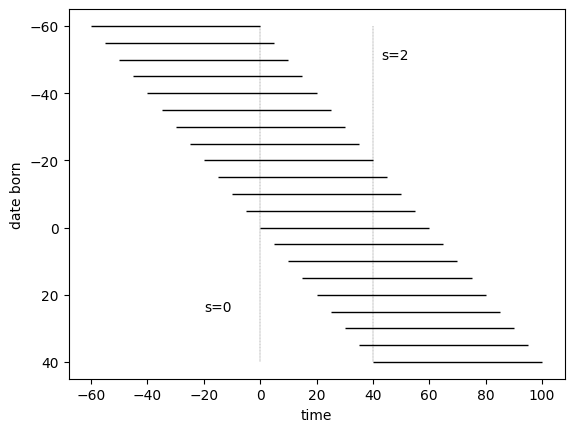

In [3]:
fig = plt.figure()

birth_range = np.arange(-60, 41, 5)
time_range = np.arange(-60, 121)

plt.hlines(birth_range, birth_range, birth_range+60, 'k', linewidth=1)
plt.vlines([0, 40], -60, 40, 'k', linestyle='--', linewidth=0.2)

plt.ylabel("date born")
plt.xlabel("time")

plt.text(-20, 25, r"s=0")
plt.text(43, -50, r"s=2")

plt.gca().invert_yaxis()
plt.show()


**Small Open Economy Transition**

In the small open economy case with fixed factor prices, the transition has a clear structure:

1. At date $s = 0$, the government announces the policy change to begin at $s_1$, which affects decision-making for all cohorts that might be alive at that time.

2. Cohorts born before $s_1 - T_0$ will have died before the policy change and are unaffected.

3. Cohorts born between $s_1 - T_0$ and $s_1$ must recalculate their consumption-saving plans for their remaining lifetimes given the announced changes.

4. Cohorts born between $s_1$ and $s_2$ face time-varying sequences of tax and benefit rates during their lives.

5. Cohorts born after $s_2$ face constant policy parameters for their entire lives.

6. The transition ends exactly at $s_3 = s_2 + T_0$ when all cohorts who experienced the policy transition have died.

Because factor prices are fixed, we can efficiently compute the transition by calculating decision rules for cohorts born at dates $s - t = s_1 - T_0 - 1, ..., s_2$. This requires fewer dynamic programs than with time-varying prices because each cohort faces a fixed pattern of rates of return, wage rates, tax rates, and benefit rates throughout life.

For any date $s$, aggregate consumption is computed by summing across all living cohorts (along a vertical line in the age-time diagram), weighted by their population fractions.

**Closed Economy Transition**

In the endogenous factor prices case, the transition dynamics are more complex:

1. The transition formally lasts indefinitely because factor prices continue to evolve even after policy parameters stabilize at $s_2$.

2. We follow Auerbach and Kotlikoff (1987) and truncate the transition at $s_3 = s_2 + 2T_0$, assuming convergence is nearly complete by this point.

3. The computation requires nested iteration procedures:
  - An inner loop determines labor income tax rates during the transition to achieve target debt levels
  - An outer loop adjusts the interest rate sequence to ensure factor markets clear

4. The transition is characterized by feedback effects:
  - Changes in capital accumulation affect interest rates and wages
  - These price changes in turn affect households' saving decisions
  - Which then further impact capital accumulation

5. The price effects propagate through time even after policy parameters have stabilized because:
  - Capital-labor ratios continue adjusting
  - Cohorts born during the transition continue making decisions based on their unique lifetime tax and benefit profiles
  - The economy converges to the new stationary equilibrium only gradually

6. Price effects complicate the welfare analysis because:
  - Lower interest rates benefit young workers (higher wages) but hurt retirees (lower returns on savings)
  - This creates additional redistributive effects beyond those intended by the policy change

This richer feedback mechanism makes the transition path in the closed economy more realistic but substantially more complex to compute.

## 3. Two Computations

Let's explore two strategies for transitioning to a fully funded social security system.

### 3.1 Compensation Through Debt

In the first experiment, the government suddenly terminates social security benefits but compensates entitled generations through a one-time increase in government debt.

Starting from an initial equilibrium with debt/GDP ratio of 0.59, social security replacement rate of 60%, and labor income tax rate of 33.9%, the key findings are:

1. "Entitlement debt" required to compensate current retirees amounts to approximately 2.7 times GDP

2. Under fixed factor prices:
  - Labor income tax rises to 36% during a 40-year transition, then drops to 8.3%
  - Capital stock rises by 66% across stationary equilibria
  - Overall efficiency gain of 1.28% of GDP

3. Under endogenous factor prices:
  - Labor income tax rises to 38% during transition, then falls to 14.2%
  - Capital stock rises by 40% across stationary equilibria
  - Rate of return on capital falls from 6.75% to 4.44%
  - Overall efficiency gain of 2.0% of GDP

### 3.2 Government Accumulation of Private Capital

In the second experiment, the government retains social security benefits but temporarily raises taxes to accumulate physical capital, the returns from which eventually finance social security payments.

Key findings:

1. Under fixed factor prices:
  - Labor income tax rises to 37.2% during transition, then falls to 13.9%
  - Capital stock rises by 65.5% across stationary equilibria
  - Government debt becomes negative (-1.18 times GDP)
  - Overall efficiency gain of 2.12% of GDP

2. Under endogenous factor prices:
  - Labor income tax rises to 39% during transition, then falls to 25%
  - Capital stock rises by 33.8% across stationary equilibria
  - Overall efficiency gain of 2.84% of GDP

### 3.3 Comparing the Two Schemes

The government-run scheme (experiment 2) delivers larger efficiency gains than privatization (experiment 1) under both price assumptions. This stems from:

1. Continued provision of insurance against life span risk
2. Partial insurance against labor income volatility through higher labor income taxes
3. Higher efficiency gains with endogenous factor prices for both experiments due to higher labor income tax rates providing implicit insurance against earnings risk

Both schemes achieve the transition to fully funded social security while maintaining welfare across generations, but through different mechanisms of intergenerational risk-sharing.

## 4. Computation Strategy


### 4.1 Dynamic Programming Problem

The household's problem can be formulated as a discounted risk-sensitive linear control problem. Let $x_t = [a_{t-1}, z_t]'$ where $z_t$ is the vector of shocks. Then:

$$U_t = x'_t \cdot P_t \cdot x_t + \xi_t$$

The recursive problem is:

$$U_t = \max_{u_t,x_{t+1}} \{u'_t \cdot Q_t \cdot u_t + x'_t \cdot R_t \cdot x_t + \frac{2 \cdot \beta_t}{\sigma} \cdot \log E_t[\exp(\sigma \cdot U_{t+1}/2)]\}$$

subject to:

$$x_{t+1} = A_t \cdot x_t + B_t \cdot u_t + C_t \cdot w_{t+1}$$

The solution is characterized by Riccati equations:

$$T_t(P) = P + \sigma \cdot P \cdot C_t(I - \sigma \cdot C'_t \cdot P \cdot C_t)^{-1} \cdot C'_t \cdot P$$
$$D_t(W) = R_t + A'_t(W - \beta^2 \cdot W \cdot B_t(Q_t + \beta \cdot B'_t \cdot W \cdot B_t)^{-1} \cdot B'_t \cdot W) \cdot A_t$$
$$S_t(k, P) = \beta_t \cdot k - \frac{\beta_t}{\sigma} \cdot \log \det(I - \sigma \cdot C'_t \cdot P \cdot C_t)$$

The optimal value function is:

$$U_t = x'_t \cdot P_t \cdot x_t + \xi_t$$

where:

$$P_t = (D_t \circ T_t) \cdot P_{t+1}$$
$$\xi_t = S_t(\xi_{t+1}, P_{t+1})$$

The optimal control is:

$$u_t = -F_t \cdot x_t$$
$$F_t = \beta[Q_t + \beta \cdot B'_t \cdot T_t(P_{t+1}) \cdot B_t]^{-1} \cdot B'_t \cdot T_t(P_{t+1}) \cdot A_t$$

### 4.2 Computing Transitions in Different Scenarios

#### Timing during the transition

A cohort born at $s$ lives during $s+0, s+1, ..., s+T_0$, and works during $s+0, s+1, ..., s+T_1$.

Let $0 \leq s_1 < s_2 < s_3$.
- At $s=0$, announces policy change between $s=s_1$ and $s=s_2$. 
- From $s=s_2$, government policies will be constant forever.
- From $s=s_3$, the convergence to final stationary equilibrium is achieved. (In small open economy, $s_3 = s_2 + T_0$.)

What cohorts are affected? Cohorts born at $s=s_1-T_0, s_1-T_0 + 1, ..., s_2$.

In all exercises, we set $T_0 = 65, T_1 = 45$ (* see note 1) and $s_1 = 0, s_2 = 40$.

#### Fixed factor price - Computation 1: Buyout
Here, $s_3 = 40 + 65 = 105$.

**Step 1**: set up parameters.

**Step 2**: solve initial stationary equilibrium, with constant social security benefit $S$. We fix all other fiscal parameters and solve for the policy $\tau_l = \tau_{l,0}$ that makes the government budget balance in the initial steady state.
```
Fix τ_a, τ_0, benef, G, Gb_bar to constants.

def F(τ_l):
    Conditions for solving a cohort's problem. 
    Produce implied government variables.
    return "government imbalance"

Find root to F(τ_l) = 0.
```

**Step 3**: solve final stationary equilibrium, with no social security. We look for government debt Gb_bar such that 

```
Fix τ_a, τ_0, benef, G to constants.

def H(Gb_bar):
    Given Gb_bar, solve for F(τ_l; Gb_bar) = 0, which yields a τ_l*. Set 
    τ_l* and compute variables implied by it.
    return debt2gdp 

Find root to H(Gb_bar) = target.
```
The associated tax on labor is $\tau_{l,2}$.


**Step 4**: solve transition path:
  - At $s=0=s_1$, the following will happen:
    - All cohorts alive will lose benefit, and cohort of age $t$ get a one-time compensation given by: 
      $$ \operatorname{comp}_t=\operatorname{ben}_t+\text {risk term}, \\ \operatorname{ben}_t=S \sum_{j=\max \left(T_1-t, 0\right)}^{T_0-t} \prod_{i=0}^j \left(R(s)\left[1-\tau_a(s)\right]+\tau_a(s)\right)$$
    - Government sets $\tau_{l,1}$ between $s_1$ and $s_2$ and sets $\tau_{l,2}$ from $s_2$ onwards.
    - Government expenditure has a one-time increase of $\sum f_t \operatorname{comp}_t$ at $s_1$.
  - We solve for $\tau_{l,1}$ such that government debt to GDP ratio in the terminal steady state equals that in the initial steady state. 

  ```
  Fix τ_a, τ_0, G to constants. benef = 0 during transition. Let Gb_bar_term be the terminal steady state Gb_bar computed above.

  def J(τ_l):
      Set τ_l, a constant, during the entire transition period.

      for cohort = 0 to T0:   # those which die at year "cohort"
        Compute comp_t

      for cohort = 0 to s3:
        Solve cohort's problem,
        compute implied variables.
      
      Compute government carryover debt to the new steady state, carryover.

      return carryover

  Find root to J(τ_l) = Gb_bar_term.
  ```
#### Fixed factor price - Computation 2
Here, $s_3 = 40 + 65 = 105$.

Now, instead of a large buyout at time 0, the government keeps the same level of social security, but moves to a regime under which the government gradually accumulates private capital, which finances social security payment. To conduct this experiment, one only needs to choose the right target terminal debt to GDP ratio which induces the government to accumulate sufficient capital.

#### Endogenous factor price 
Here, $s_3 = 40 + 2 \times 65 = 170$. Assume that after TT = T0 periods following the policy transition periods 40, the economy is close enough to the terminal steady state.

**Step 1**: set up parameters.

**Step 2**: solve initial stationary equilibrium, same as above.

**Step 3**: solve final stationary equilibrium, with no social security. Again, we look for government debt Gb_bar such that debt2gdp is the same as in the initial steady state.

**Step 4**: solve the transition path. Now the factor price sequences are endogenously determined.

```
def T(R_seq):
  # Force the last T0 periods of R_seq to be constant at new steady state levels.

  1. Compute the MPL sequence associated with the R sequence. 
  
  2. Take the price sequences as given, find root to J(τ_l) = Gb_bar_terminal, as in the above case.

  3. Compute the path of aggregate capital stock implied by the solution, compute the MPK, Rstar, and define diff = Rstar - R_seq.

  return diff

Solve T(R_seq) = 0 using a secant search algorithm with relaxation method to update R_seq_new, until convergence of interest rate.

```

## Technical details for Solving LQ Problem

The transition equation is: 

$$
\begin{align*}
c_{t}(s)+a_{t}(s)&={\color{blue}\left[R(s-1)-\tau_{t}^{a}(s)\left(R(s-1)-1\right)\right]a_{t-1}(s-1)}+{\color{orange}\left(1-\tau_{\ell}(s)\right)w(s)\varepsilon_{t}-\tau_{0}(s)+S_{t}(s)}+{\color{brown}\left(1-\tau_{\ell}(s)\right)d_{t}}\\d_{t}&=\rho_{d}d_{t-1}+\epsilon_{t}
\end{align*}
$$

Let $s$ denote the flow of time and $t$ denote the age of the cohort. This can be mapped to:

$$
\begin{align*}
\boldsymbol{x}_{t+1}&=\boldsymbol{A}_{t}\boldsymbol{x}_{t}+\boldsymbol{B}\boldsymbol{u}_{t}+\boldsymbol{C}\boldsymbol{w}_{t+1}\\\left[\begin{array}{c}
a_{t}(s)\\
1\\
d_{t+1}
\end{array}\right]&=\left[\begin{array}{ccc}
R(s-1)\left(1-\tau_{t}^{a}(s)\right)+\tau_{t}^{a}(s) & \left(1-\tau_{\ell}(s)\right)w(s)\varepsilon_{t}-\tau_{0}(s)+S_{t}\left(s\right) & \mathbf{1}_{t}^{\text{working}}\left(1-\tau_{\ell}(s)\right)\\
0 & 1 & 0\\
0 & 0 & \rho_{d}
\end{array}\right]\left[\begin{array}{c}
a_{t-1}(s-1)\\
1\\
d_{t}
\end{array}\right]+\left[\begin{array}{c}
-1\\
0\\
0
\end{array}\right]c_{t}(s)+\left[\begin{array}{c}
0\\
0\\
1
\end{array}\right]\epsilon_{t}
\end{align*}
$$

where $\mathbf{1}_{t}^{\text{working}}$ is an indicator function of whether a cohort is working.
An agent solves the following recursive problem: 

$$
\begin{align*}
U_{t}&=\max_{\boldsymbol{u}_{t}}\left[\boldsymbol{u}_{t}^{\prime}\boldsymbol{Q}\boldsymbol{u}_{t}+\boldsymbol{x}_{t}^{\prime}\boldsymbol{R}\boldsymbol{x}_{t}+2\boldsymbol{u}_{t}^{\prime}\boldsymbol{H}\boldsymbol{x}_{t}+\beta_{t}\mathcal{R}_{t}\left(U_{t+1}\right)\right]\\\text{s.t. }&\boldsymbol{x}_{t+1}=\boldsymbol{A}_{t}\boldsymbol{x}_{t}+\boldsymbol{B}\boldsymbol{u}_{t}+\boldsymbol{C}\boldsymbol{w}_{t+1}
\end{align*}
$$

where 

$$
\mathcal{R}_{t}\left(U_{t+1}\right)=(2/\sigma)\log E\left[\exp\left(\sigma U_{t+1}/2\right)\mid J_{t}\right]
$$

The $Q, R, H$ matrices are given by:

$$
\begin{align*}
&\boldsymbol{u}_{t}^{\prime}\boldsymbol{Q}\boldsymbol{u}_{t}+\boldsymbol{x}_{t}^{\prime}\boldsymbol{R}\boldsymbol{x}_{t}+2\boldsymbol{u}_{t}^{\prime}\boldsymbol{H}\boldsymbol{x}_{t}\\=&-.5\left(\pi c_{t}-\gamma\right)^{2}\\=&-.5\pi^{2}c_{t}^{2}+\pi\gamma c_{t}-.5\gamma^{2}\\=&\left[\begin{array}{ccc}
a_{t}(s) & 1 & d_{t}\end{array}\right]\left[\begin{array}{ccc}
0 & 0 & 0\\
0 & -.5\gamma^{2} & 0\\
0 & 0 & 0
\end{array}\right]\left[\begin{array}{c}
\begin{array}{c}
a_{t}(s)\\
1\\
d_{t}
\end{array}\end{array}\right]+\left(-.5\pi^{2}c_{t}^{2}\right)+2c_{t}\left[\begin{array}{ccc}
0 & .5\pi\gamma & 0\end{array}\right]\left[\begin{array}{c}
\begin{array}{c}
a_{t}(s)\\
1\\
d_{t}
\end{array}\end{array}\right]
\end{align*}
$$

Notice that we can eliminate the cross-product by taking the following transformation of it into a standard LQ problem. See: https://python.quantecon.org/cross_product_trick.html.

$$
\begin{align*}
A^{*}&=A-BQ^{-1}H\\R^{*}&=R-H^{\prime}Q^{-1}H\\F^{*}&=\left(Q+B^{\prime}PB\right)^{-1}B^{\prime}PA^{*}
\end{align*}
$$

One can then solve the optimal value function and control by applying the following iterative procedure (Hansen and Sargent, 1995 and Appendix):

$$
\begin{aligned}
&U_t=x_t^{\prime} \boldsymbol{P}_t x_t+\xi_t\\
\boldsymbol{P}_t & =\left(D_t \circ T_t\right) \boldsymbol{P}_{t+1}, \\
\xi_t & =\mathcal{S}_t\left(\xi_{t+1}, \boldsymbol{P}_{t+1}\right) .
\end{aligned}
$$

with operators defined by:

$$
\begin{gathered}
T_t(\boldsymbol{P})=\boldsymbol{P}+\sigma \boldsymbol{P} \boldsymbol{C}_t\left(I-\sigma \boldsymbol{C}_t^{\prime} \boldsymbol{P} \boldsymbol{C}_t\right)^{-1} \boldsymbol{C}_t^{\prime} \boldsymbol{P} \\
D_t(\boldsymbol{W})=\boldsymbol{R}_t+\boldsymbol{A}_t^{\prime}\left[\beta \boldsymbol{W}-\beta^2 \boldsymbol{W} \boldsymbol{B}_t\left(\boldsymbol{Q}_t+\beta \boldsymbol{B}_t^{\prime} \boldsymbol{W} \boldsymbol{B}_t\right)^{-1} \boldsymbol{B}_t^{\prime} \boldsymbol{W}\right] \boldsymbol{A}_t \\
\mathcal{S}_t(k, \boldsymbol{P})=\beta_t k-\left(\beta_t / \sigma\right) \log \operatorname{det}\left(I-\sigma \boldsymbol{C}_t^{\prime} \boldsymbol{P} \boldsymbol{C}_t\right)
\end{gathered}
$$

The optimal control is

$$
\begin{gathered}
u_t=-\boldsymbol{F}_t x_t, \\
\boldsymbol{F}_t=\beta\left[\boldsymbol{Q}_t+\beta \boldsymbol{B}_t^{\prime} T_t\left(\boldsymbol{P}_{t+1}\right) \boldsymbol{B}_t\right]^{-1} \boldsymbol{B}_t^{\prime} T_t\left(\boldsymbol{P}_{t+1}\right) \boldsymbol{A}_t .
\end{gathered}
$$

#### Mean, Variance and Covariances
Define $A_o = A - BF$. Then, 

$$ 
x_{t+1}=A_o x_t+C w_{t+1} 
$$

Unconditional means and covariances moves according to:

$$
\begin{align*}
\mu_{t+1}&=A_{o,t}\mu_{t}\\\Sigma_{t+1}&=A_{o,t}\Sigma_{t}A_{o,t}^{\prime}+CC^{\prime}
\end{align*}
$$

And the autocovariance matrices are calculated by:
$$
\Sigma_{t+j,t}=\left(\Pi_{i=0}^{j-1}A_{o,t+i}\right)\Sigma_{t}
$$

We can also build the large autocovariance matrix:

$$
V=\left[\begin{array}{ccccc}
\Sigma_{0} & A_{o,0}^{1}\Sigma_{0} &  & \cdots & \left(\Pi_{i=0}^{T-1}A_{o,i}\right)\Sigma_{0}\\
A_{o,0}^{1}\Sigma_{0} & \Sigma_{1} & A_{o,1}^{1}\Sigma_{1} & \cdots & \vdots\\
\vdots & A_{o,1}^{1}\Sigma_{1} & \Sigma_{2}\\
 & \vdots &  & \ddots & \vdots\\
\left(\Pi_{i=0}^{T-1}A_{o,i}\right)\Sigma_{0} & \cdots &  & \cdots & \Sigma_{T}
\end{array}\right]
$$



Let's start solving the numerical problem below.

## Parameter setup and initial values

#### Table 1: Preference Parameters

| Parameter | Description | Value |
|-----------|-------------|-------|
| $\{{\alpha_t}\}_{t=0}^{T_0}$ | Age-to-age survival probabilities | Faber (1982) |
| $\pi$ | Consumption preference parameter | 1.0 |
| $\sigma$ | Risk-sensitivity parameter | -0.05 |
| $\bar{\gamma}$ | Preference shock parameter | 7.0 |
| $\tilde{\beta}$ | Discount factor | 0.986 |
| $T_0$ | Maximum age | 65 |
| $T_1$ | Retirement age | 45 |
| $n$ | Gross population growth rate | 1.012 |

#### Table 2: Technology Parameters

| Parameter | Description | Value |
|-----------|-------------|-------|
| $k_{-1}$ | Initial capital endowment | 4.0 |
| $\sigma_d$ | Standard deviation of income shock | 0.85 |
| $\rho_d$ | Persistence of income shock | 0.8 |
| $\delta$ | Depreciation rate | 0.06 |
| $\{{\varepsilon_t}\}_{t=0}^{T_1}$ | Age-efficiency profile | Hansen (1991) |
| **Exogenous Factor Prices** | | |
| $w$ | Base wage rate | 5.0147 |
| $r$ | Return on capital | 0.1275 |
| **Endogenous Factor Prices** | | |
| $A$ | Production function scaling | 2.2625 |
| $\tilde{\alpha}$ | Capital share | 0.40 |

In [4]:
N_GRID_SS = 10  # Grid size for steady-state root finding
TOL_SS = 1e-10

# Model dimensions
T0 = 65   # Maximum lifespan (ages 21 to 86)
T1 = 43   # Working life length (retire at 65)

# Pre-computed global arrays (fixed hyperparameters)
UNIT_GRID = jnp.linspace(0.0, 1.0, N_GRID_SS)  # For grid refinement searches
AGE_INDICES = jnp.arange(T0 + 2)               # Age iteration indices

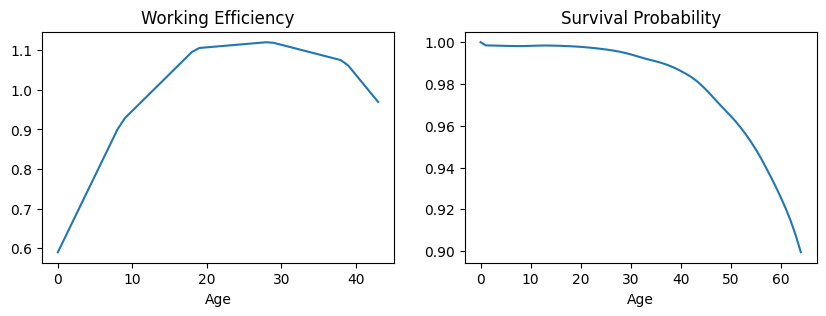

In [5]:
ε_arr, α_arr = jnp.load("eff.npy"), jnp.load("psurv.npy")

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(ε_arr)
axs[0].set_title(r"Working Efficiency")
axs[0].set_xlabel("Age")

axs[1].plot(α_arr)
axs[1].set_title(r"Survival Probability")
axs[1].set_xlabel(r"Age")

plt.show()

In [6]:
# terminal values
P_end = jnp.zeros((3, 3))
P_end = P_end.at[0, 0].set(-2000000.0)  # large penalty on holding asset in the last period
ξ_end = 0.0

# initial conditions
x0 = jnp.array([4.0, 1.0, 0.0])
Σ0 = jnp.zeros((3, 3))

In [7]:
Household = namedtuple('Household', (
    'α_arr', 'frac', 'n', 'π', 'σ', 'k_init', 'ε_arr', 'Ind_work',
    'σ_d', 'ρ_d', 'γ_bar', 'β_arr',
    'T0', 'T1', 'T2', 'n_x', 'n_w',
    'P_end', 'ξ_end', 'x0', 'Σ0',
    'B', 'C', 'R', 'Q', 'H'
))

def create_household(α_arr=α_arr,    # Age-to-age survival probabilities
                     n=1.012,        # Gross population growth rate
                     π=1,            # Consumption preference parameter	
                     σ=-0.05,        # Risk-sensitivity parameter
                     k_init=4,       # initial capital endowment
                     ε_arr=ε_arr,    # age-efficiency profile
                     σ_d=0.85,       # std of income shock
                     ρ_d=0.8,        # persistence of income shock
                     γ_bar=7,        # Preference shock parameter
                     β_tilde=0.986,  # Discount factor
                     T0=65,          # Maximum age
                     T1=43,          # Retirement age
                     n_x=3,          # Number of states
                     n_w=1,          # Number of shocks
                     P_end=P_end,    # Terminal value
                     ξ_end=ξ_end,    # Terminal value
                     x0=x0,          # Initial mean
                     Σ0=Σ0):         # Initial variance
    
    α_arr = np.concatenate([α_arr, np.array([0])])
    T2 = T0 - T1
    
    frac = np.ones(T0 + 1)
    frac[1:] = np.cumprod(α_arr / n)[:-1]
    frac = frac / frac.sum()
    
    ε_arr = np.concatenate([ε_arr, np.zeros(T0 + 1 - ε_arr.size)])
    
    # Indicator for working ages: 1 if working (ε > 0), 0 if retired
    Ind_work = (ε_arr != 0).astype(np.float64)
    
    β_arr = β_tilde * α_arr
    β_arr[-1] = β_tilde
    
    B = jnp.array([[-1.0, 0.0, 0.0]]).T
    C = jnp.array([[0.0, 0.0, σ_d]]).T
    
    R = jnp.array([[0.0, 0.0, 0.0],
                   [0.0, -0.5 * γ_bar**2, 0.0],
                   [0.0, 0.0, 0.0]])
    Q = jnp.array([[-0.5 * π**2]])
    H = jnp.array([[0.0, 0.5 * π * γ_bar, 0.0]])
    
    Q_inv = jnp.array([[1.0 / (-0.5 * π**2)]])
    R_np = np.array([[0.0, 0.0, 0.0],
                     [0.0, -0.5 * γ_bar**2, 0.0],
                     [0.0, 0.0, 0.0]])
    H_np = np.array([[0.0, 0.5 * π * γ_bar, 0.0]])
    Q_inv_np = np.array([[1.0 / (-0.5 * π**2)]])
    R_np = R_np - H_np.T @ Q_inv_np @ H_np
    R = jnp.array(R_np)
    
    return Household(
        α_arr=jnp.array(α_arr), frac=jnp.array(frac), n=n, π=π, σ=σ,
        k_init=k_init, ε_arr=jnp.array(ε_arr), Ind_work=jnp.array(Ind_work),
        σ_d=σ_d, ρ_d=ρ_d, γ_bar=γ_bar, β_arr=jnp.array(β_arr),
        T0=T0, T1=T1, T2=T2, n_x=n_x, n_w=n_w,
        P_end=P_end, ξ_end=ξ_end, x0=x0, Σ0=Σ0,
        B=B, C=C, R=R, Q=Q, H=H
    )

In [8]:
hh = create_household()

hh

Household(α_arr=DeviceArray([1.     , 0.99851, 0.99844, 0.99838, 0.99832, 0.99826,
             0.9982 , 0.99816, 0.99815, 0.99819, 0.99826, 0.99834,
             0.9984 , 0.99843, 0.99841, 0.99835, 0.99828, 0.99818,
             0.99807, 0.99794, 0.99778, 0.99759, 0.99737, 0.99712,
             0.99684, 0.99653, 0.99619, 0.9958 , 0.99535, 0.99481,
             0.99419, 0.9935 , 0.99278, 0.99209, 0.99148, 0.99088,
             0.99021, 0.98942, 0.98851, 0.98746, 0.98625, 0.98495,
             0.9835 , 0.98178, 0.97974, 0.97743, 0.97489, 0.97226,
             0.96965, 0.96715, 0.96466, 0.962  , 0.95907, 0.9559 ,
             0.95246, 0.94872, 0.9446 , 0.94017, 0.93555, 0.93077,
             0.9257 , 0.9203 , 0.91431, 0.90742, 0.89948, 0.     ],            dtype=float64), frac=DeviceArray([0.02542014, 0.02511871, 0.02478388, 0.0244518 , 0.02412271,
             0.02379663, 0.02347354, 0.02315344, 0.0228368 , 0.02252426,
             0.02221689, 0.02191525, 0.02161944, 0.0213289 , 0.02104

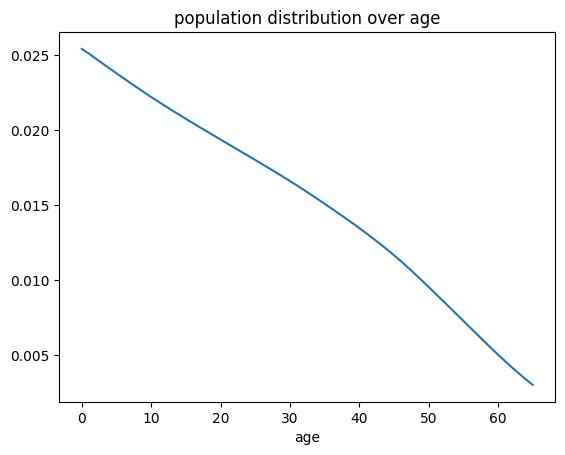

In [9]:
plt.plot(hh.frac)
plt.xlabel(r"age")
plt.title("population distribution over age")
plt.show()

The population distribution above shows that the model has a realistic age structure, with the fraction of the population declining with age due to mortality. This demographic structure is crucial for capturing the intergenerational transfer aspects of social security reform.

### Technology Parameters

Next, we define the technology parameters for the production function and factor prices. Under the exogenous price assumption (small open economy), factor prices are fixed at calibrated values. Under the endogenous price assumption (closed economy), prices are determined by marginal products from a Cobb-Douglas production function.

In [10]:
Tech = namedtuple('Tech', ('δ', 'w', 'r', 'RR', 'A', 'α_tilde'))

def create_Tech(δ=0.06,        # depreciation rate
                w=5.0147,      # base wage rate (exogenous price)
                r=0.1275,      # return on capital (exogenous price)
                A=2.2625,      # production function scaling (endogenous price)
                α_tilde=0.40): # capital share (endogenous price)

    # gross return on capital (exogenous price)
    RR = 1 + r - δ

    return Tech(δ=δ, w=w, r=r, RR=RR, A=A, α_tilde=α_tilde)

In [11]:
tech = create_Tech()

## Solving the Household's Dynamic Programming Problem

We now implement the core computational machinery to solve the household's optimization problem. The `solve_riccati` function performs one step of backward iteration to solve the Riccati equation associated with the LQ problem. Given the value function parameters at age $t+1$, it computes:
- The optimal decision rule $F_t$ (linear feedback policy for consumption)
- The closed-loop transition matrix $A_t^o$
- The value function quadratic $P_t$ and linear $\xi_t$ terms

In [12]:
@jit
def solve_riccati_step(ε_t, β_t, Ind_work_t, RR, w, τ_l, τ_a, τ_0, benef,
                       P_next, ξ_next, ρ_d, σ, B, C, R, Q, H):

    A = jnp.array([
        [RR * (1.0 - τ_a) + τ_a,
         (1.0 - τ_l) * w * ε_t - τ_0 + benef * (1.0 - Ind_work_t),
         (1.0 - τ_l) * Ind_work_t],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, ρ_d]
    ])
    
    Q_scalar = Q[0, 0]
    Q_inv_scalar = 1.0 / Q_scalar
    Q_inv = jnp.array([[Q_inv_scalar]])
    
    A = A - B @ Q_inv @ H
    
    CTP = C.T @ P_next @ C
    PP_scalar = 1.0 - σ * CTP[0, 0]
    PP_inv_scalar = 1.0 / PP_scalar
    
    PC = P_next @ C
    CP = C.T @ P_next
    TP = P_next + σ * PP_inv_scalar * (PC @ CP)
    
    BTB_scalar = (B.T @ TP @ B)[0, 0]
    Q_BTB_scalar = Q_scalar + β_t * BTB_scalar
    Q_BTB_inv_scalar = 1.0 / Q_BTB_scalar
    
    BT_TP = B.T @ TP
    BT_TP_A = BT_TP @ A
    F = β_t * Q_BTB_inv_scalar * BT_TP_A
    
    TP_B = TP @ B
    middle = β_t * TP - β_t**2 * Q_BTB_inv_scalar * (TP_B @ BT_TP)
    P = R + A.T @ middle @ A
    
    log_det_PP = jnp.log(PP_scalar)
    ξ = jnp.where(σ != 0.0,
                  β_t * (ξ_next - log_det_PP / σ),
                  β_t * (ξ_next + CTP[0, 0]))
    
    Ao = A - B @ F
    F = F + Q_inv @ H
    
    return F.squeeze(), Ao, P, ξ

### Steady State Computation

The `ss_imbalance` function computes the government budget imbalance in a steady state. It:
1. Solves the household problem backward from terminal age to compute decision rules
2. Simulates forward to compute asset distributions across ages
3. Aggregates tax revenues and expenditures to calculate fiscal imbalance

A steady state is found when this imbalance equals zero.

In [13]:
@jit
def _ss_imbalance(price, policy, α_arr, ε_arr, frac, n, 
                        β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                        Ind_work):

    # Infer n_x from input arrays
    n_x = x0.shape[0]
    
    RR, w = price
    τ_l, τ_a, τ_0, benef, G, Gb = policy
    
    # Backward recursion using scan (iterate from T0 down to 0)
    # Reverse ε_arr, β_arr, Ind_work for backward iteration
    ε_rev = ε_arr[::-1]
    β_rev = β_arr[::-1]
    Ind_work_rev = Ind_work[::-1]
    
    def backward_step(carry, inputs):
        P_next, ξ_next = carry
        ε_t, β_t, Ind_work_t = inputs
        
        F, Ao, P, ξ = solve_riccati_step(
            ε_t, β_t, Ind_work_t, RR, w, τ_l, τ_a, τ_0, benef,
            P_next, ξ_next,
            ρ_d, σ, B, C, R, Q, H
        )
        
        return (P, ξ), (F, Ao, P, ξ)
    
    init_carry = (P_end, ξ_end)
    _, (F_rev, Ao_rev, P_rev, ξ_rev) = lax.scan(
        backward_step, init_carry, (ε_rev, β_rev, Ind_work_rev)
    )
    
    # Reverse outputs to get forward order (age 0 to T0)
    F_arr = F_rev[::-1]
    Ao_arr = Ao_rev[::-1]
    P_inner = P_rev[::-1]
    ξ_inner = ξ_rev[::-1]
    
    # Build full P_arr and ξ_arr with terminal conditions
    P_arr = jnp.concatenate([P_inner, P_end[None, :, :]], axis=0)
    ξ_arr = jnp.concatenate([ξ_inner, jnp.array([ξ_end])])
    
    # Forward simulation using scan
    CCT = C @ C.T
    
    def forward_step(carry, inputs):
        μx_t, Σx_t = carry
        Ao_t, F_t = inputs
        
        μx_next = Ao_t @ μx_t
        μc_t = -F_t @ μx_t
        Σx_next = CCT + Ao_t @ Σx_t @ Ao_t.T
        Vc_t = F_t @ Σx_t @ F_t.T
        
        return (μx_next, Σx_next), (μx_next, μc_t, Σx_next, Vc_t)
    
    init_carry = (x0, Σ0)
    final_carry, (μx_arr, μc_arr, Σx_arr, Vc_arr) = lax.scan(
        forward_step, init_carry, (Ao_arr, F_arr)
    )
    
    # Build full μx_arr and Σx_arr with initial conditions
    μx_arr = jnp.concatenate([x0[None, :], μx_arr], axis=0)
    Σx_arr = jnp.concatenate([Σ0[None, :, :], Σx_arr], axis=0)
    
    μa_arr = μx_arr[1:, 0]
    μa_last_arr = μx_arr[:-1, 0]
    
    # Tax revenues - use Ind_work for retired mask
    τ_l_tot = jnp.sum(τ_l * ε_arr * w * frac)
    τ_a_tot = jnp.sum(τ_a * (RR - 1.0) * μa_last_arr * frac)
    τ_0_tot = jnp.sum(τ_0 * frac)
    
    # Benefits only for retirees (Ind_work == 0)
    retired_mask = 1.0 - Ind_work
    benef_tot = jnp.sum(benef * frac * retired_mask)
    
    Beq = jnp.sum(RR * (1.0 - α_arr) * frac * μa_arr / n)
    
    T_tot = τ_l_tot + τ_a_tot + τ_0_tot + Beq
    diff = G + benef_tot - T_tot + (RR / n - 1.0) * Gb
    
    return diff, P_arr, ξ_arr, Ao_arr, F_arr, μx_arr, μc_arr, Σx_arr, Vc_arr


def ss_imbalance(price, policy, hh, tech):
    """Calculate government budget imbalance in steady state."""
    RR, w = price
    τ_l, τ_a, τ_0, benef, G, Gb = policy
    price_arr = jnp.array([RR, w])
    policy_arr = jnp.array([τ_l, τ_a, τ_0, benef, G, Gb])
    
    return _ss_imbalance(
        price_arr, policy_arr,
        hh.α_arr, hh.ε_arr, hh.frac, hh.n,
        hh.β_arr, hh.ρ_d, hh.σ, hh.B, hh.C, hh.R, hh.Q, hh.H,
        hh.P_end, hh.ξ_end, hh.x0, hh.Σ0,
        hh.Ind_work
    )

In [14]:
SteadyState = namedtuple("SteadyState", (
    "P_arr",     # Value function matrices by age
    "ξ_arr",     # Certainty equivalent adjustments by age
    "Ao_arr",    # Closed-loop transition matrices by age
    "F_arr",     # Decision rule matrices by age
    "μx_arr",    # Mean state vectors by age
    "μc_arr",    # Mean consumption by age
    "Σx_arr",    # Covariance matrices by age
    "Vc_arr",    # Consumption variances by age
    "debt2gdp",  # Government debt to GDP ratio
    "τ_l",       # Labor income tax rate
    "benef",     # Social security benefit level
    "Gb",        # Per-capita government debt
    "k_bar",     # Per-capita capital stock
    "RR",        # Gross return on assets
    "w",         # Wage rate
    "r",         # Interest rate (before depreciation)
    "k2gdp"      # Capital to GDP ratio
))

The `find_ss_exo` function finds the equilibrium steady state under exogenous (fixed) prices. It uses bisection to search for the labor income tax rate $\tau_l$ that balances the government budget. The function wraps `ss_imbalance` in a root-finding routine.

In [15]:
@jit
def _ss_diff_for_tau_l(τ_l, price_arr, policy_no_τl, α_arr, ε_arr, frac, n,
                        β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                        Ind_work):

    τ_a, τ_0, benef, G, Gb = policy_no_τl
    policy_arr = jnp.array([τ_l, τ_a, τ_0, benef, G, Gb])
    diff, *_ = _ss_imbalance(
        price_arr, policy_arr,
        α_arr, ε_arr, frac, n,
        β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
        Ind_work
    )
    return diff


@jit
def _find_ss_tau_l(price_arr, policy_no_τl, α_arr, ε_arr, frac, n,
                    β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                    Ind_work, unit_grid):

    a_init, b_init = -0.5, 1.0 - 1e-5
    n_grid = unit_grid.shape[0]
    
    def compute_diff(τ_l):
        return _ss_diff_for_tau_l(
            τ_l, price_arr, policy_no_τl, α_arr, ε_arr, frac, n,
            β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
            Ind_work
        )
    
    def cond_fn(state):
        a, b, best_val, i = state
        return (jnp.abs(best_val) > TOL_SS) & (i < 10)
    
    def body_fn(state):
        a, b, _, i = state
        grid = a + (b - a) * unit_grid  # Rescale unit grid to [a, b]
        diffs = vmap(compute_diff)(grid)
        best_idx = jnp.argmin(jnp.abs(diffs))
        best_val = diffs[best_idx]
        idx_lo = jnp.maximum(best_idx - 1, 0)
        idx_hi = jnp.minimum(best_idx + 1, n_grid - 1)
        a_new = grid[idx_lo]
        b_new = grid[idx_hi]
        return (a_new, b_new, best_val, i + 1)
    
    # Initial grid evaluation
    grid = a_init + (b_init - a_init) * unit_grid
    diffs = vmap(compute_diff)(grid)
    best_idx = jnp.argmin(jnp.abs(diffs))
    best_val = diffs[best_idx]
    idx_lo = jnp.maximum(best_idx - 1, 0)
    idx_hi = jnp.maximum(best_idx + 1, n_grid - 1)
    
    init_state = (grid[idx_lo], grid[idx_hi], best_val, 0)
    final_state = lax.while_loop(cond_fn, body_fn, init_state)
    a_final, b_final, _, _ = final_state
    
    return (a_final + b_final) / 2.0


def find_ss_exo(price, policy_target, hh, tech):
    """Find steady state with exogenous prices by solving for τ_l."""
    frac, ε_arr, n, x0 = hh.frac, hh.ε_arr, hh.n, hh.x0
    RR, w = price
    r = RR - 1 + tech.δ
    
    τ_a, τ_0, benef, G, Gb = policy_target
    
    price_arr = jnp.array([RR, w])
    policy_no_τl = jnp.array([τ_a, τ_0, benef, G, Gb])
    
    τ_l = _find_ss_tau_l(
        price_arr, policy_no_τl,
        hh.α_arr, hh.ε_arr, hh.frac, hh.n,
        hh.β_arr, hh.ρ_d, hh.σ, hh.B, hh.C, hh.R, hh.Q, hh.H,
        hh.P_end, hh.ξ_end, hh.x0, hh.Σ0,
        hh.Ind_work, UNIT_GRID
    )
    
    diff, P_arr, ξ_arr, Ao_arr, F_arr, μx_arr, μc_arr, Σx_arr, Vc_arr = \
        ss_imbalance((RR, w), (float(τ_l), τ_a, τ_0, benef, G, Gb), hh, tech)
    
    μa_arr = μx_arr[1:, 0]
    
    ε_agg = jnp.sum(frac * ε_arr)
    a_agg = jnp.sum(frac * μa_arr)
    k_agg = a_agg - Gb
    k_share = r * (k_agg / n + frac[0] * x0[0])
    l_share = w * ε_agg
    gdp = k_share + l_share
    
    debt2gdp = Gb / gdp
    k2gdp = k_agg / gdp
    
    return SteadyState(
        P_arr=P_arr, ξ_arr=ξ_arr, Ao_arr=Ao_arr, F_arr=F_arr,
        μx_arr=μx_arr, μc_arr=μc_arr, Σx_arr=Σx_arr, Vc_arr=Vc_arr,
        debt2gdp=float(debt2gdp), τ_l=float(τ_l), benef=benef, Gb=Gb, 
        k_bar=float(k_agg), RR=RR, w=w, r=float(r), k2gdp=float(k2gdp)
    )

In [16]:
aveinc = tech.w * sum(hh.ε_arr) / (hh.T1+1)
θ = .6    # social security replacement rate

benef_0 = aveinc * θ

# policy targets in the initial economy
G_0 = 1.44
Gb_0 = 2.8 * G_0
τ_l_0 = .3385
τ_a_0 = .30
τ_0_0 = 0

# exogenous price
RR, w = tech.RR, tech.w

### Computing the Initial and Terminal Steady States

We now compute the initial steady state (with social security) and the terminal steady state (after reform). The initial steady state has:
- Positive social security benefits (`benef_0`)
- A calibrated replacement rate ($\theta = 0.6$)
- Government expenditure and debt set to match targets

In [17]:
# Timing Parameters
S_exo = 140
S_endo = 200
S1, S2 = 0, 40
S3 = S2 + 2 * hh.T0

RR_exo, w_exo = tech.RR, tech.w

In [18]:
ss0 = find_ss_exo((RR, w), (τ_a_0, τ_0_0, benef_0, G_0, Gb_0), hh, tech)

print(f"\nInitial Steady State (s < 0):")
print(f"  Labor tax τ_l = {ss0.τ_l:.4f}")
print(f"  Interest rate r - δ = {ss0.r - tech.δ:.4f}")
print(f"  Capital/GDP = {ss0.k2gdp:.4f}")
print(f"  Debt/GDP = {ss0.debt2gdp:.4f}")


Initial Steady State (s < 0):
  Labor tax τ_l = 0.3383
  Interest rate r - δ = 0.0675
  Capital/GDP = 3.1615
  Debt/GDP = 0.5899


In [19]:
Gb_arr = np.linspace(0.5 * Gb_0, 1.5 * Gb_0, 20)
τl_arr = np.empty_like(Gb_arr)
debt2gdp_arr = np.empty_like(Gb_arr)

for i, Gb in enumerate(Gb_arr):
    
    ss = find_ss_exo((RR, w), (τ_a_0, τ_0_0, 0, G_0, Gb), hh, tech)
    τl_arr[i] = ss.τ_l
    debt2gdp_arr[i] = ss.debt2gdp

Text(0, 0.5, 'debt2gdp')

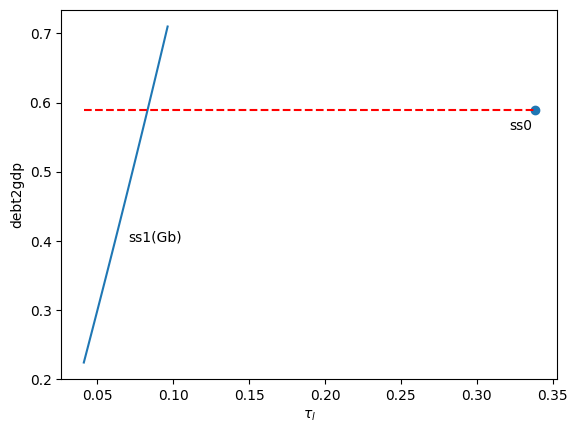

In [20]:
plt.plot(τl_arr, debt2gdp_arr)
plt.hlines(ss0.debt2gdp, τl_arr.min(), np.maximum(τl_arr.max(), ss0.τ_l), linestyle='--', color='r')

plt.scatter(ss0.τ_l, ss0.debt2gdp)
plt.text(ss0.τ_l*0.95, ss0.debt2gdp*0.95, "ss0")
plt.text(0.07, 0.4, "ss1(Gb)")

plt.xlabel('$τ_l$')
plt.ylabel('debt2gdp')

The figure above illustrates how the equilibrium labor tax rate varies with government debt. The upward-sloping relationship reflects the fact that higher debt requires larger interest payments, which must be financed through higher taxes. The red dashed lines show the initial steady state: we locate the tax rate that achieves the target debt-to-GDP ratio.

In [21]:
@jit
def _compute_debt2gdp_for_Gb(Gb, price_arr, policy_no_Gb, α_arr, ε_arr, frac, n,
                              β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0, 
                              δ, Ind_work, unit_grid):

    RR, w = price_arr
    τ_a, τ_0, benef, G = policy_no_Gb
    r = RR - 1 + δ
    n_grid = unit_grid.shape[0]
    
    policy_no_τl = jnp.array([τ_a, τ_0, benef, G, Gb])
    
    def compute_ss_diff(τ_l):
        return _ss_diff_for_tau_l(
            τ_l, price_arr, policy_no_τl, α_arr, ε_arr, frac, n,
            β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
            Ind_work
        )
    
    def cond_fn(state):
        a, b, best_val, i = state
        return (jnp.abs(best_val) > TOL_SS) & (i < 10)
    
    def body_fn(state):
        a, b, _, i = state
        grid = a + (b - a) * unit_grid
        diffs = vmap(compute_ss_diff)(grid)
        best_idx = jnp.argmin(jnp.abs(diffs))
        best_val = diffs[best_idx]
        idx_lo = jnp.maximum(best_idx - 1, 0)
        idx_hi = jnp.minimum(best_idx + 1, n_grid - 1)
        return (grid[idx_lo], grid[idx_hi], best_val, i + 1)
    
    a_init, b_init = -0.5, 1.0 - 1e-5
    grid = a_init + (b_init - a_init) * unit_grid
    diffs = vmap(compute_ss_diff)(grid)
    best_idx = jnp.argmin(jnp.abs(diffs))
    best_val = diffs[best_idx]
    idx_lo = jnp.maximum(best_idx - 1, 0)
    idx_hi = jnp.minimum(best_idx + 1, n_grid - 1)
    
    init_state = (grid[idx_lo], grid[idx_hi], best_val, 0)
    final_state = lax.while_loop(cond_fn, body_fn, init_state)
    a_final, b_final, _, _ = final_state
    τ_l = (a_final + b_final) / 2.0
    
    # Compute ss_imbalance to get μx_arr
    policy_arr = jnp.array([τ_l, τ_a, τ_0, benef, G, Gb])
    
    _, _, _, _, _, μx_arr, _, _, _ = _ss_imbalance(
        price_arr, policy_arr,
        α_arr, ε_arr, frac, n,
        β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
        Ind_work
    )
    
    μa_arr = μx_arr[1:, 0]
    ε_agg = jnp.sum(frac * ε_arr)
    a_agg = jnp.sum(frac * μa_arr)
    k_agg = a_agg - Gb
    k_share = r * (k_agg / n + frac[0] * x0[0])
    l_share = w * ε_agg
    gdp = k_share + l_share
    
    return Gb / gdp


@jit
def _find_Gb_for_debt2gdp(debt2gdp_target, price_arr, policy_no_Gb, α_arr, ε_arr, frac, n,
                           β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0, 
                           δ, Ind_work, unit_grid, unit_grid_tau):

    a_init, b_init = -40.0, 20.0
    n_grid = unit_grid.shape[0]
    
    # Pre-compute τ_l grid (fixed bounds)
    τ_l_grid = -0.5 + (1.0 - 1e-5 - (-0.5)) * unit_grid_tau
    
    # Unpack for use inside nested function
    RR, w = price_arr
    τ_a, τ_0, benef, G = policy_no_Gb
    
    def compute_diff_coarse(Gb):
        r = RR - 1 + δ
        
        policy_no_τl = jnp.array([τ_a, τ_0, benef, G, Gb])
        
        def compute_ss_diff(τ_l):
            return _ss_diff_for_tau_l(
                τ_l, price_arr, policy_no_τl, α_arr, ε_arr, frac, n,
                β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                Ind_work
            )
        
        diffs = vmap(compute_ss_diff)(τ_l_grid)
        best_idx = jnp.argmin(jnp.abs(diffs))
        τ_l = τ_l_grid[best_idx]
        
        policy_arr = jnp.array([τ_l, τ_a, τ_0, benef, G, Gb])
        _, _, _, _, _, μx_arr, _, _, _ = _ss_imbalance(
            price_arr, policy_arr,
            α_arr, ε_arr, frac, n,
            β_arr, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
            Ind_work
        )
        μa_arr = μx_arr[1:, 0]
        ε_agg = jnp.sum(frac * ε_arr)
        a_agg = jnp.sum(frac * μa_arr)
        k_agg = a_agg - Gb
        k_share = r * (k_agg / n + frac[0] * x0[0])
        l_share = w * ε_agg
        gdp = k_share + l_share
        return Gb / gdp - debt2gdp_target
    
    def cond_fn(state):
        a, b, best_val, i = state
        return (jnp.abs(best_val) > TOL_SS) & (i < 5)
    
    def body_fn(state):
        a, b, _, i = state
        grid = a + (b - a) * unit_grid
        diffs = vmap(compute_diff_coarse)(grid)
        best_idx = jnp.argmin(jnp.abs(diffs))
        best_val = diffs[best_idx]
        idx_lo = jnp.maximum(best_idx - 1, 0)
        idx_hi = jnp.minimum(best_idx + 1, n_grid - 1)
        return (grid[idx_lo], grid[idx_hi], best_val, i + 1)
    
    grid = a_init + (b_init - a_init) * unit_grid
    diffs = vmap(compute_diff_coarse)(grid)
    best_idx = jnp.argmin(jnp.abs(diffs))
    idx_lo = jnp.maximum(best_idx - 1, 0)
    idx_hi = jnp.minimum(best_idx + 1, n_grid - 1)
    
    init_state = (grid[idx_lo], grid[idx_hi], diffs[best_idx], 0)
    final_state = lax.while_loop(cond_fn, body_fn, init_state)
    a_final, b_final, _, _ = final_state
    
    return (a_final + b_final) / 2.0


def ss_target_debt2gdp_exo(debt2gdp_target, policy_target, price, hh, tech):
    """Find steady state with target debt-to-GDP ratio."""
    τ_a, τ_0, benef, G = policy_target
    RR, w = price
    
    price_arr = jnp.array([RR, w])
    policy_no_Gb = jnp.array([τ_a, τ_0, benef, G])
    
    Gb = _find_Gb_for_debt2gdp(
        float(debt2gdp_target), price_arr, policy_no_Gb,
        hh.α_arr, hh.ε_arr, hh.frac, hh.n,
        hh.β_arr, hh.ρ_d, hh.σ, hh.B, hh.C, hh.R, hh.Q, hh.H,
        hh.P_end, hh.ξ_end, hh.x0, hh.Σ0, tech.δ,
        hh.Ind_work, UNIT_GRID, UNIT_GRID
    )
    
    return find_ss_exo((RR, w), (τ_a, τ_0, benef, G, float(Gb)), hh, tech)

In [22]:
ss1 = ss_target_debt2gdp_exo(
    ss0.debt2gdp, (τ_a_0, τ_0_0, 0, G_0), (RR_exo, w_exo), hh, tech
)

print(f"\nTerminal Steady State (s ≥ s₃):")
print(f"  Labor tax τ_l = {ss1.τ_l:.4f}")
print(f"  Benefits θ = 0")
print(f"  Capital/GDP = {ss1.k2gdp:.4f}")
print(f"  Debt/GDP = {ss1.debt2gdp:.4f}")


Terminal Steady State (s ≥ s₃):
  Labor tax τ_l = 0.0832
  Benefits θ = 0
  Capital/GDP = 4.1563
  Debt/GDP = 0.5910


## Transition Path Computation

With the steady states computed, we now turn to the transition dynamics. The transition path describes how the economy moves from the initial steady state (with social security) to the terminal steady state (after reform).

### Key Functions

The `solve_backwards` function solves the household problem backward in time during the transition, computing optimal decision rules at each calendar date and age combination. This is more complex than the steady-state computation because prices and policies change over time.

The `simulate_forwards` function takes the computed decision rules and simulates the economy forward from the initial distribution, tracking the evolution of asset means and variances across cohorts.

In [23]:
@jit
def _solve_backwards(price_seq, policy_seq, P_arr_ss1, ξ_arr_ss1,
                           ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end,
                           s_indices, ages):

    # Infer dimensions from input arrays
    n_x = P_end.shape[0]
    S = s_indices.shape[0] - 1
    
    def solve_all_ages(P_next_all, ξ_next_all, RR_s, w_s, τ_l, τ_a, τ_0, benef):
        def solve_one_age(t, P_next, ξ_next):
            ε_t = ε_arr[t]
            β_t = β_arr[t]
            Ind_work_t = Ind_work[t]
            F, Ao, P, ξ = solve_riccati_step(
                ε_t, β_t, Ind_work_t, RR_s, w_s, τ_l, τ_a, τ_0, benef,
                P_next, ξ_next, ρ_d, σ, B, C, R, Q, H
            )
            return F, Ao, P, ξ
        
        P_next_shifted = P_next_all[1:]
        ξ_next_shifted = ξ_next_all[1:]
        
        F_all, Ao_all, P_all, ξ_all = vmap(solve_one_age)(ages, P_next_shifted, ξ_next_shifted)
        return F_all, Ao_all, P_all, ξ_all
    
    def scan_body(carry, s_inv):
        P_next_seq, ξ_next_seq = carry
        s = S - s_inv
        
        RR_s = price_seq[s, 0]
        w_s = price_seq[s, 1]
        τ_l = policy_seq[s, 0]
        τ_a = policy_seq[s, 1]
        τ_0 = policy_seq[s, 2]
        benef = policy_seq[s, 3]
        
        F_s, Ao_s, P_s, ξ_s = solve_all_ages(
            P_next_seq, ξ_next_seq, RR_s, w_s, τ_l, τ_a, τ_0, benef
        )
        
        # Build P_curr and ξ_curr using the known shapes from input arrays
        P_curr = jnp.zeros_like(P_arr_ss1)
        P_curr = P_curr.at[:T0+1].set(P_s)
        P_curr = P_curr.at[-1].set(P_end)
        
        ξ_curr = jnp.zeros_like(ξ_arr_ss1)
        ξ_curr = ξ_curr.at[:T0+1].set(ξ_s)
        ξ_curr = ξ_curr.at[-1].set(ξ_end)
        
        output = (F_s, Ao_s, P_s, ξ_s)
        new_carry = (P_curr, ξ_curr)
        
        return new_carry, output
    
    init_carry = (P_arr_ss1, ξ_arr_ss1)
    
    # s_indices already has the right length
    _, outputs = lax.scan(scan_body, init_carry, s_indices)
    
    F_seq, Ao_seq, P_seq_inner, ξ_seq_inner = outputs
    
    F_seq = jnp.flip(F_seq, axis=0)
    Ao_seq = jnp.flip(Ao_seq, axis=0)
    
    # Build output arrays using shapes from price_seq
    P_seq = jnp.zeros((price_seq.shape[0], P_arr_ss1.shape[0], n_x, n_x))
    ξ_seq = jnp.zeros((price_seq.shape[0], ξ_arr_ss1.shape[0]))
    
    P_seq_inner = jnp.flip(P_seq_inner, axis=0)
    ξ_seq_inner = jnp.flip(ξ_seq_inner, axis=0)
    P_seq = P_seq.at[:S+1, :T0+1].set(P_seq_inner)
    ξ_seq = ξ_seq.at[:S+1, :T0+1].set(ξ_seq_inner)
    
    P_seq = P_seq.at[:, -1].set(P_end)
    ξ_seq = ξ_seq.at[:, -1].set(ξ_end)
    P_seq = P_seq.at[-1, :].set(P_arr_ss1)
    ξ_seq = ξ_seq.at[-1, :].set(ξ_arr_ss1)
    
    return F_seq, Ao_seq, P_seq, ξ_seq


def solve_backwards(price_seq, policy_seq, P_arr_ss1, ξ_arr_ss1, hh, tech, S):
    """Wrapper for backward solve."""
    # Pre-create iteration arrays (use slicing for variants)
    s_indices = jnp.arange(S + 2)
    return _solve_backwards(
        price_seq, policy_seq, P_arr_ss1, ξ_arr_ss1,
        hh.ε_arr, hh.β_arr, hh.Ind_work, hh.ρ_d, hh.σ, hh.B, hh.C, hh.R, hh.Q, hh.H,
        hh.P_end, hh.ξ_end, s_indices[:-1], AGE_INDICES[:-1]
    )

In [24]:
@jit
def _simulate_forwards(Ao_seq, F_seq, μx_init, Σx_init, C, x0, Σ0, s_indices, ages):

    # Infer dimensions from input arrays
    n_x = x0.shape[0]
    CCT = C @ C.T
    S = s_indices.shape[0] - 1
    
    def simulate_all_ages(μx_curr, Σx_curr, Ao_s, F_s):
        def simulate_one_age(t, μx_t, Σx_t, Ao_t, F_t):
            μx_next = Ao_t @ μx_t
            μc_t = -F_t @ μx_t
            Σx_next = CCT + Ao_t @ Σx_t @ Ao_t.T
            Vc_t = F_t @ Σx_t @ F_t.T
            return μx_next, μc_t, Σx_next, Vc_t
        
        μx_next_all, μc_all, Σx_next_all, Vc_all = vmap(simulate_one_age)(
            ages, μx_curr[:T0+1], Σx_curr[:T0+1], Ao_s, F_s
        )
        return μx_next_all, μc_all, Σx_next_all, Vc_all
    
    def scan_body(carry, s):
        μx_curr, Σx_curr = carry
        
        Ao_s = Ao_seq[s]
        F_s = F_seq[s]
        
        μx_next_inner, μc_s, Σx_next_inner, Vc_s = simulate_all_ages(
            μx_curr, Σx_curr, Ao_s, F_s
        )
        
        # Use shapes from μx_init
        μx_next = jnp.zeros_like(μx_init)
        μx_next = μx_next.at[0].set(x0)
        μx_next = μx_next.at[1:T0+2].set(μx_next_inner)
        
        Σx_next = jnp.zeros_like(Σx_init)
        Σx_next = Σx_next.at[0].set(Σ0)
        Σx_next = Σx_next.at[1:T0+2].set(Σx_next_inner)
        
        output = (μx_curr, μc_s, Σx_curr, Vc_s)
        new_carry = (μx_next, Σx_next)
        
        return new_carry, output
    
    init_carry = (μx_init, Σx_init)
    final_carry, outputs = lax.scan(scan_body, init_carry, s_indices)
    
    μx_seq_inner, μc_seq, Σx_seq_inner, Vc_seq = outputs
    
    # Build output arrays using inferred sizes
    μx_seq = jnp.zeros((S + 2, T0 + 2, n_x))
    Σx_seq = jnp.zeros((S + 2, T0 + 2, n_x, n_x))
    
    μx_seq = μx_seq.at[:S+1].set(μx_seq_inner)
    Σx_seq = Σx_seq.at[:S+1].set(Σx_seq_inner)
    
    μx_seq = μx_seq.at[S+1].set(final_carry[0])
    Σx_seq = Σx_seq.at[S+1].set(final_carry[1])
    
    return μx_seq, μc_seq, Σx_seq, Vc_seq


def simulate_forwards(Ao_seq, F_seq, μx_init, Σx_init, hh, S):
    """Wrapper for forward simulation."""
    # Pre-create iteration arrays (use slicing for variants)
    s_indices = jnp.arange(S + 2)
    return _simulate_forwards(
        Ao_seq, F_seq, μx_init, Σx_init,
        hh.C, hh.x0, hh.Σ0, s_indices[:-1], AGE_INDICES[:-1]
    )

The `transition_paths` function is the workhorse for computing transition dynamics. Given a candidate transition tax rate $\tau_l^{\text{trans}}$, it:
1. Constructs the complete policy sequence by combining initial, transition, and terminal policies
2. Solves backward for decision rules under the given prices and policies
3. Simulates forward to compute aggregate outcomes
4. Returns the debt path, which can be used to check if the transition satisfies budget constraints

The function also accepts an optional `compensation` callback to handle experiment-specific compensation schemes (like the buy-out in Experiment 1).

In [25]:
@jit
def _transition_paths(τ_l_trans, price_seq, policy_seq, 
                            ss1_P_arr, ss1_ξ_arr, ss1_Gb,
                            μx_init, Σx_init, k_bar_init,
                            s_indices, age_range,
                            S1, S2,
                            ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                            frac, n):

    # Infer dimensions from input arrays
    n_x = x0.shape[0]
    S = s_indices.shape[0] - 2
    
    # Derive variants via slicing
    s_indices_scan = s_indices[:-1]      # arange(S+1)
    ages = age_range[:-1]                 # arange(T0+1)
    capital_indices = s_indices[1:-1]    # arange(1, S+1)
    
    # Update policy sequence with transition tax using dynamic indexing
    mask = (s_indices >= S1 + 1) & (s_indices <= S2)
    τ_l_col = jnp.where(mask, τ_l_trans, policy_seq[:, 0])
    policy_seq = policy_seq.at[:, 0].set(τ_l_col)
    
    # Solve backwards
    F_seq, Ao_seq, P_seq, ξ_seq = _solve_backwards(
        price_seq, policy_seq, ss1_P_arr, ss1_ξ_arr,
        ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, s_indices_scan, ages
    )
    
    # Simulate forwards
    μx_seq, μc_seq, Σx_seq, Vc_seq = _simulate_forwards(
        Ao_seq, F_seq, μx_init, Σx_init, C, x0, Σ0, s_indices_scan, ages
    )
    
    # Compute capital path
    ε_agg = jnp.sum(ε_arr * frac)
    frac0_x0 = frac[0] * x0[0]
    
    def capital_step(k_prev, s):
        RR = price_seq[s, 0]
        w = price_seq[s, 1]
        G = policy_seq[s, 4]
        c_agg = jnp.sum(μc_seq[s] * frac)
        k_new = RR * (frac0_x0 + k_prev / n) - G - c_agg + w * ε_agg
        return k_new, k_new
    
    # capital_indices is pre-created arange(1, S+1)
    _, k_path = lax.scan(capital_step, k_bar_init, capital_indices)
    k_seq = jnp.concatenate([jnp.array([k_bar_init]), k_path])
    
    # Compute debt path
    a_seq = jnp.sum(μx_seq[1:, 1:, 0] * frac, axis=1)
    Gb_seq = a_seq - k_seq
    
    carryover = Gb_seq[-1] - ss1_Gb
    
    return carryover, μx_seq, μc_seq, k_seq, Gb_seq, F_seq, Ao_seq


def transition_paths(τ_l_trans, price_seq, policy_seq, ss0, ss1, hh, tech, S, S1, S2,
                     μx_init, Σx_init):
    """Compute transition path."""
    policy_seq = jnp.asarray(policy_seq)
    price_seq = jnp.asarray(price_seq)
    
    # Pre-create iteration arrays (use slicing for variants)
    s_indices = jnp.arange(S + 2)
    
    carryover, μx_seq, μc_seq, k_seq, Gb_seq, F_seq, Ao_seq = _transition_paths(
        float(τ_l_trans), price_seq, policy_seq,
        ss1.P_arr, ss1.ξ_arr, float(ss1.Gb),
        μx_init, Σx_init, float(ss0.k_bar),
        s_indices, AGE_INDICES,
        S1, S2,
        hh.ε_arr, hh.β_arr, hh.Ind_work, hh.ρ_d, hh.σ, hh.B, hh.C, hh.R, hh.Q, hh.H,
        hh.P_end, hh.ξ_end, hh.x0, hh.Σ0,
        hh.frac, hh.n
    )
    
    return float(carryover), μx_seq, μc_seq, k_seq, Gb_seq, F_seq, Ao_seq

### Illustrating the Shooting Method

To find the correct transition tax rate, we use a shooting method. The figure below shows the debt paths for two candidate tax rates. If the tax rate is too low, debt explodes; if it is too high, debt collapses below the target. The equilibrium tax rate is found where the terminal debt exactly hits the target.

In [26]:
# Price and policy sequences
price_seq = jnp.column_stack([
    jnp.full(S_exo + 2, RR), 
    jnp.full(S_exo + 2, w)
])

policy_seq_base = jnp.empty((S_exo + 2, 6))
policy_seq_base = policy_seq_base.at[:S1 + 1, 0].set(ss0.τ_l)
policy_seq_base = policy_seq_base.at[S2 + 1:, 0].set(ss1.τ_l)
policy_seq_base = policy_seq_base.at[:, 1].set(τ_a_0)
policy_seq_base = policy_seq_base.at[:, 2].set(τ_0_0)
policy_seq_base = policy_seq_base.at[:, 3].set(0)
policy_seq_base = policy_seq_base.at[:, 4].set(G_0)
policy_seq_base = policy_seq_base.at[:, 5].set(Gb_0)

In [27]:
# Test two candidate tax rates to illustrate shooting
τ_l_low = 0.14
τ_l_high = 0.17

_, μx_seq1, μc_seq1, k_seq1, Gb_seq1, _, _ = transition_paths(
    τ_l_low, price_seq, policy_seq_base, ss0, ss1, hh, tech, S_exo, S1, S2, ss0.μx_arr, ss0.Σx_arr
)

_, μx_seq2, μc_seq2, k_seq2, Gb_seq2, _, _ = transition_paths(
    τ_l_high, price_seq, policy_seq_base, ss0, ss1, hh, tech, S_exo, S1, S2, ss0.μx_arr, ss0.Σx_arr
)

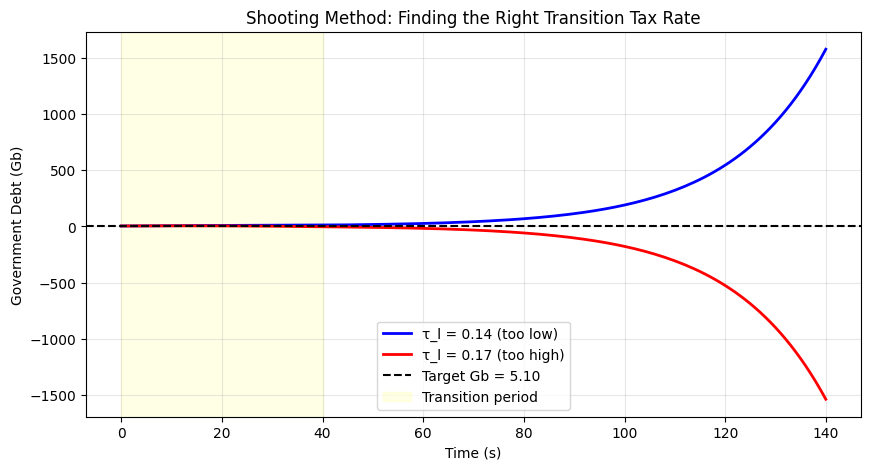

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Gb_seq1, 'b-', linewidth=2, label=f'τ_l = {τ_l_low:.2f} (too low)')
ax.plot(Gb_seq2, 'r-', linewidth=2, label=f'τ_l = {τ_l_high:.2f} (too high)')
ax.axhline(ss1.Gb, color='k', linestyle='--', label=f'Target Gb = {ss1.Gb:.2f}')
ax.axvspan(S1, S2, alpha=0.1, color='yellow', label='Transition period')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Government Debt (Gb)')
ax.set_title('Shooting Method: Finding the Right Transition Tax Rate')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

The figure above demonstrates the shooting approach: the blue curve shows debt increasing when the tax rate is too low (Debt explodes), while the orange curve shows debt decreasing when the tax rate is too high (Debt overshoots target). The equilibrium transition tax rate lies between these two extremes.

### Finding the Equilibrium Transition Tax Rate

The `find_transition_exo` function automates this shooting procedure using Brent's method for root-finding. It searches for the tax rate that makes terminal debt equal to the target debt-to-GDP ratio.

In [29]:
@jit
def _compute_compensation_jit(death_time, τ_l_seq, τ_a_seq, benef_diff, RR_seq, w_seq, ε_arr, indices, ss0_τ_l):

    n_periods = death_time + 1
    age_at_0 = T0 - death_time
    
    time_mask = indices < n_periods
    age_mask = indices >= age_at_0
    
    τ_l_cohort = jnp.where(time_mask, τ_l_seq[:T0 + 1], 0.0)
    τ_a_cohort = jnp.where(time_mask, τ_a_seq[:T0 + 1], 0.0)
    RR_cohort = jnp.where(time_mask, RR_seq[:T0 + 1], 1.0)
    w_cohort = jnp.where(time_mask, w_seq[:T0 + 1], 0.0)
    
    ε_masked = jnp.where(age_mask, ε_arr, 0.0)
    benef_masked = jnp.where(age_mask, benef_diff, 0.0)
    benef_masked = jnp.where(ε_masked != 0, 0.0, benef_masked)
    
    ε_cohort = jnp.where(time_mask, ε_arr[jnp.clip(age_at_0 + indices, 0, T0)], 0.0)
    benef_cohort = jnp.where(time_mask, benef_diff[jnp.clip(age_at_0 + indices, 0, T0)], 0.0)
    benef_cohort = jnp.where(ε_cohort != 0, 0.0, benef_cohort)
    
    RR_tilde_seq = RR_cohort - τ_a_cohort * (RR_cohort - 1)
    RR_tilde_seq = jnp.where(time_mask, RR_tilde_seq, 1.0)
    discount_factors = jnp.cumprod(RR_tilde_seq)
    
    labor_loss = w_cohort * ε_cohort * (τ_l_cohort - ss0_τ_l)
    
    pv_seq = jnp.where(time_mask, (benef_cohort + labor_loss) / discount_factors, 0.0)
    
    valid = (death_time >= 0) & (death_time < T0)
    return jnp.where(valid, jnp.sum(pv_seq), 0.0)


@jit
def _apply_compensation_jit(μx_arr_ss0, Σx_arr_ss0, τ_l_seq, τ_a_seq, benef_diff,
                             RR_seq, w_seq, ε_arr, ss0_τ_l, ages_full, ages, x0, Σ0,
                             comp_mult):

    def compute_comp_for_age(age):
        death_time = T0 - age
        comp = _compute_compensation_jit(
            death_time, τ_l_seq, τ_a_seq, benef_diff, RR_seq, w_seq, ε_arr, ages, ss0_τ_l
        )
        valid = (age >= 1) & (age <= T0)
        return jnp.where(valid, comp, 0.0)
    
    compensations = vmap(compute_comp_for_age)(ages_full)
    
    μx_init = jnp.zeros_like(μx_arr_ss0)
    Σx_init = jnp.zeros_like(Σx_arr_ss0)
    
    μx_init = μx_init.at[0].set(x0)
    Σx_init = Σx_init.at[0].set(Σ0)
    μx_init = μx_init.at[-1].set(x0)
    Σx_init = Σx_init.at[-1].set(Σ0)
    
    μx_init = μx_init.at[1:-1].set(μx_arr_ss0[1:-1])
    Σx_init = Σx_init.at[1:-1].set(Σx_arr_ss0[1:-1])
    
    # Multiply by comp_mult: 0.0 means no compensation, 1.0 means full compensation
    μx_init = μx_init.at[:, 0].add(comp_mult * compensations)
    
    return μx_init, Σx_init


def apply_compensation(μx_arr_ss0, Σx_arr_ss0, τ_l_seq, τ_a_seq, benef_diff,
                       RR_seq, w_seq, hh, ss0_τ_l):
    """Apply compensation wrapper."""
    return _apply_compensation_jit(
        μx_arr_ss0, Σx_arr_ss0, τ_l_seq, τ_a_seq, benef_diff,
        RR_seq, w_seq, hh.ε_arr, ss0_τ_l, AGE_INDICES, AGE_INDICES[:-1], hh.x0, hh.Σ0,
        1.0  # comp_mult = 1.0 for full compensation
    )

In [30]:
@jit
def _transition_carryover(τ_l_trans, price_seq, policy_seq,
                           ss1_P_arr, ss1_ξ_arr, ss1_Gb,
                           ss0_μx_arr, ss0_Σx_arr, k_bar_init,
                           benef_diff, ss0_τ_l, comp_mult,
                           s_indices, age_range,
                           S1, S2,
                           ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                           frac, n):

    ages = age_range[:-1]  # arange(T0+1)
    
    # Update policy sequence with transition tax
    mask = (s_indices >= S1 + 1) & (s_indices <= S2)
    τ_l_col = jnp.where(mask, τ_l_trans, policy_seq[:, 0])
    policy_seq_updated = policy_seq.at[:, 0].set(τ_l_col)
    
    # Compute initial conditions (compensation zeroed when comp_mult=0.0)
    μx_init, Σx_init = _apply_compensation_jit(
        ss0_μx_arr, ss0_Σx_arr,
        policy_seq_updated[:, 0], policy_seq_updated[:, 1], benef_diff,
        price_seq[:, 0], price_seq[:, 1], ε_arr, ss0_τ_l, age_range, ages, x0, Σ0,
        comp_mult
    )
    
    carryover, *_ = _transition_paths(
        τ_l_trans, price_seq, policy_seq,
        ss1_P_arr, ss1_ξ_arr, ss1_Gb,
        μx_init, Σx_init, k_bar_init,
        s_indices, age_range,
        S1, S2,
        ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
        frac, n
    )
    return carryover


@jit
def _find_transition_tau_l(price_seq, policy_seq, bounds,
                            ss1_P_arr, ss1_ξ_arr, ss1_Gb,
                            ss0_μx_arr, ss0_Σx_arr, k_bar_init,
                            benef_diff, ss0_τ_l, comp_mult,
                            s_indices, age_range,
                            S1, S2,
                            ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
                            frac, n):
    """Find transition τ_l using bisection. comp_mult controls compensation (0.0 or 1.0)."""
    a, b = bounds[0], bounds[1]
    
    def compute_carryover(τ_l_trans):
        return _transition_carryover(
            τ_l_trans, price_seq, policy_seq,
            ss1_P_arr, ss1_ξ_arr, ss1_Gb,
            ss0_μx_arr, ss0_Σx_arr, k_bar_init,
            benef_diff, ss0_τ_l, comp_mult,
            s_indices, age_range,
            S1, S2,
            ε_arr, β_arr, Ind_work, ρ_d, σ, B, C, R, Q, H, P_end, ξ_end, x0, Σ0,
            frac, n
        )
    
    def cond_fn(state):
        a, b, fa, fb, i = state
        return (jnp.abs(b - a) > 1e-10) & (i < 100)
    
    def body_fn(state):
        a, b, fa, fb, i = state
        c = (a + b) / 2.0
        fc = compute_carryover(c)
        a_new = jnp.where(fa * fc > 0, c, a)
        b_new = jnp.where(fa * fc > 0, b, c)
        fa_new = jnp.where(fa * fc > 0, fc, fa)
        fb_new = jnp.where(fa * fc > 0, fb, fc)
        return (a_new, b_new, fa_new, fb_new, i + 1)
    
    fa, fb = compute_carryover(a), compute_carryover(b)
    init_state = (a, b, fa, fb, 0)
    final_state = lax.while_loop(cond_fn, body_fn, init_state)
    a_final, b_final, _, _, _ = final_state
    
    return (a_final + b_final) / 2.0

In [31]:
def find_transition_exo(price_seq, policy_seq_base, ss0, ss1,
                        hh, tech, S, S1, S2,
                        compensation_data=None,
                        τl_bounds=(0.01, 0.6)):
    """
    Find transition tax rate under exogenous prices.
    
    Parameters
    ----------
    compensation_data : tuple or None
        If provided, (benef_diff, ss0_τ_l) tuple for buyout compensation.
        If None, no compensation applied.
    """
    policy_seq = jnp.asarray(policy_seq_base)
    price_seq = jnp.asarray(price_seq)
    bounds = jnp.array([τl_bounds[0], τl_bounds[1]])
    s_indices = jnp.arange(S + 2)
    
    # Set up compensation parameters (default zeros when not using compensation)
    if compensation_data is not None:
        benef_diff, ss0_τ_l = compensation_data
        comp_mult = 1.0
    else:
        benef_diff = jnp.zeros(hh.T0 + 1)
        ss0_τ_l = ss0.τ_l
        comp_mult = 0.0
    
    # Find transition tax using unified function
    τ_l_trans = _find_transition_tau_l(
        price_seq, policy_seq, bounds,
        ss1.P_arr, ss1.ξ_arr, float(ss1.Gb),
        ss0.μx_arr, ss0.Σx_arr, float(ss0.k_bar),
        benef_diff, float(ss0_τ_l), comp_mult,
        s_indices, AGE_INDICES,
        S1, S2,
        hh.ε_arr, hh.β_arr, hh.Ind_work, hh.ρ_d, hh.σ, hh.B, hh.C, hh.R, hh.Q, hh.H,
        hh.P_end, hh.ξ_end, hh.x0, hh.Σ0,
        hh.frac, hh.n
    )
    τ_l_trans = float(τ_l_trans)
    
    # Compute final results with initial conditions
    mask = (s_indices >= S1 + 1) & (s_indices <= S2)
    τ_l_col = jnp.where(mask, τ_l_trans, policy_seq[:, 0])
    policy_seq_final = policy_seq.at[:, 0].set(τ_l_col)
    
    μx_init, Σx_init = _apply_compensation_jit(
        ss0.μx_arr, ss0.Σx_arr,
        policy_seq_final[:, 0], policy_seq_final[:, 1], benef_diff,
        price_seq[:, 0], price_seq[:, 1], hh.ε_arr, float(ss0_τ_l), 
        AGE_INDICES, AGE_INDICES[:-1], hh.x0, hh.Σ0,
        comp_mult
    )
    
    results = transition_paths(
        τ_l_trans, price_seq, policy_seq,
        ss0, ss1, hh, tech, S, S1, S2,
        μx_init, Σx_init
    )
    
    return τ_l_trans, results

In [32]:
# Find the correct transition tax rate
τ_l_trans, results = find_transition_exo(
        price_seq, policy_seq_base, ss0, ss1,
        hh, tech, S_exo, S1, S2
    )

carryover, μx_seq, μc_seq, k_seq, Gb_seq, F_seq, Ao_seq = results

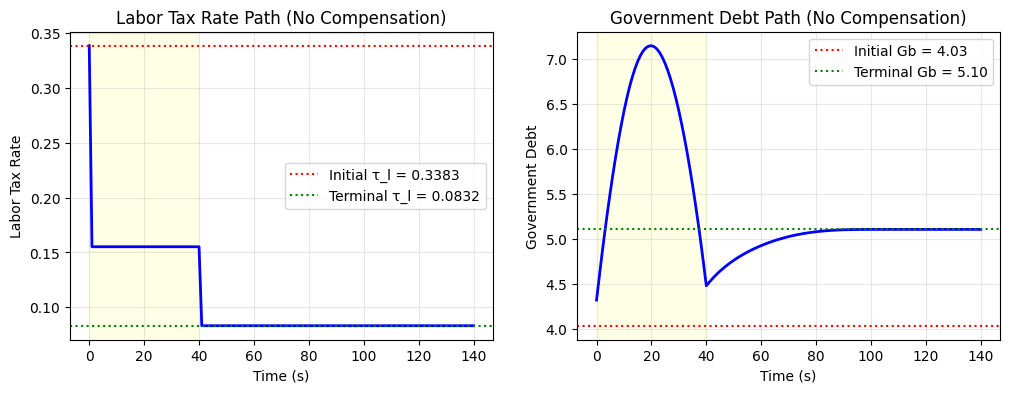

In [33]:
# Construct τ_l sequence
τ_l_seq = np.zeros(S_exo + 1)
τ_l_seq[:S1 + 1] = ss0.τ_l
τ_l_seq[S1 + 1:S2 + 1] = τ_l_trans
τ_l_seq[S2 + 1:] = ss1.τ_l

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(τ_l_seq, 'b-', linewidth=2)
axes[0].axhline(ss0.τ_l, color='r', linestyle=':', label=f'Initial τ_l = {ss0.τ_l:.4f}')
axes[0].axhline(ss1.τ_l, color='g', linestyle=':', label=f'Terminal τ_l = {ss1.τ_l:.4f}')
axes[0].axvspan(S1, S2, alpha=0.1, color='yellow')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Labor Tax Rate')
axes[0].set_title('Labor Tax Rate Path (No Compensation)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(Gb_seq, 'b-', linewidth=2)
axes[1].axhline(ss0.Gb, color='r', linestyle=':', label=f'Initial Gb = {ss0.Gb:.2f}')
axes[1].axhline(ss1.Gb, color='g', linestyle=':', label=f'Terminal Gb = {ss1.Gb:.2f}')
axes[1].axvspan(S1, S2, alpha=0.1, color='yellow')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Government Debt')
axes[1].set_title('Government Debt Path (No Compensation)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

In the baseline case (no compensation), social security benefits are simply terminated. We now compute the equilibrium transition path and compare results with and without the buy-out compensation scheme.

## Buy-out

The buy-out scheme compensates generations that lose social security benefits. The compensation is calculated to be actuarially fair: each affected cohort receives a transfer equal to the present value of the social security benefits they would have received.

The `compute_compensation` function calculates the compensation amount for each cohort based on their remaining lifespan, survival probabilities, and the difference in benefit levels before and after reform.

The `apply_compensation` function modifies the government budget and individual income to implement the transfers.

### fixed price

In [34]:
RR_exo, w_exo = tech.RR, tech.w

ss1_exp1_exo = ss_target_debt2gdp_exo(
    ss0.debt2gdp, (τ_a_0, τ_0_0, 0, G_0), (RR_exo, w_exo), hh, tech
)

In [35]:
# Price and policy sequences
price_seq_exp1_exo = jnp.column_stack([
    jnp.full(S_exo + 2, RR_exo), 
    jnp.full(S_exo + 2, w_exo)
])

policy_seq_exp1_exo = jnp.empty((S_exo + 2, 6))
policy_seq_exp1_exo = policy_seq_exp1_exo.at[:S1 + 1, 0].set(ss0.τ_l)
policy_seq_exp1_exo = policy_seq_exp1_exo.at[S2 + 1:, 0].set(ss1_exp1_exo.τ_l)
policy_seq_exp1_exo = policy_seq_exp1_exo.at[:, 1].set(τ_a_0)
policy_seq_exp1_exo = policy_seq_exp1_exo.at[:, 2].set(τ_0_0)
policy_seq_exp1_exo = policy_seq_exp1_exo.at[:, 3].set(0)
policy_seq_exp1_exo = policy_seq_exp1_exo.at[:, 4].set(G_0)
policy_seq_exp1_exo = policy_seq_exp1_exo.at[:, 5].set(Gb_0)

In [36]:
# Benefit difference for compensation
benef_diff_exp1 = jnp.zeros(hh.T0 + 1)
benef_diff_exp1 = benef_diff_exp1.at[hh.T1 + 1:].set(ss0.benef)

In [37]:
# Define buyout compensation callback
def buyout_compensation_exp1_exo(τ_l_trans, policy_seq_base, price_seq):
    policy_seq = policy_seq_base.copy()
    policy_seq[S1 + 1:S2 + 1, 0] = τ_l_trans
    return apply_compensation(
        ss0.μx_arr, ss0.Σx_arr,
        policy_seq[:, 0], policy_seq[:, 1], benef_diff_exp1,
        price_seq[:, 0], price_seq[:, 1], hh, ss0.τ_l
    )

# Solve with buyout
τ_l_exp1_exo_bo, results_exp1_exo_bo = find_transition_exo(
    price_seq_exp1_exo, policy_seq_exp1_exo, ss0, ss1_exp1_exo,
    hh, tech, S_exo, S1, S2,
    compensation_data=(benef_diff_exp1, ss0.τ_l)
)

# Solve without buyout (for comparison)
τ_l_exp1_exo_nb, results_exp1_exo_nb = find_transition_exo(
    price_seq_exp1_exo, policy_seq_exp1_exo, ss0, ss1_exp1_exo,
    hh, tech, S_exo, S1, S2
)

### Results: Experiment 1 with Fixed Prices

The figure below compares the transition paths with and without buy-out compensation under fixed (exogenous) prices. We examine four key variables:
- **Capital stock ($K$)**: How private capital accumulation responds to the reform
- **Government debt ($G_b$)**: The fiscal implications of each scheme
- **Mean consumption**: Aggregate consumption dynamics during transition
- **Mean asset holdings**: Wealth accumulation patterns across cohorts

In [38]:
# Store for later use
exp1_exo = {
    'ss0': ss0, 'ss1': ss1_exp1_exo,
    'τ_l_buyout': τ_l_exp1_exo_bo, 'τ_l_no_buyout': τ_l_exp1_exo_nb,
    'results_buyout': results_exp1_exo_bo, 'results_no_buyout': results_exp1_exo_nb,
    'hh': hh, 'tech': tech
}

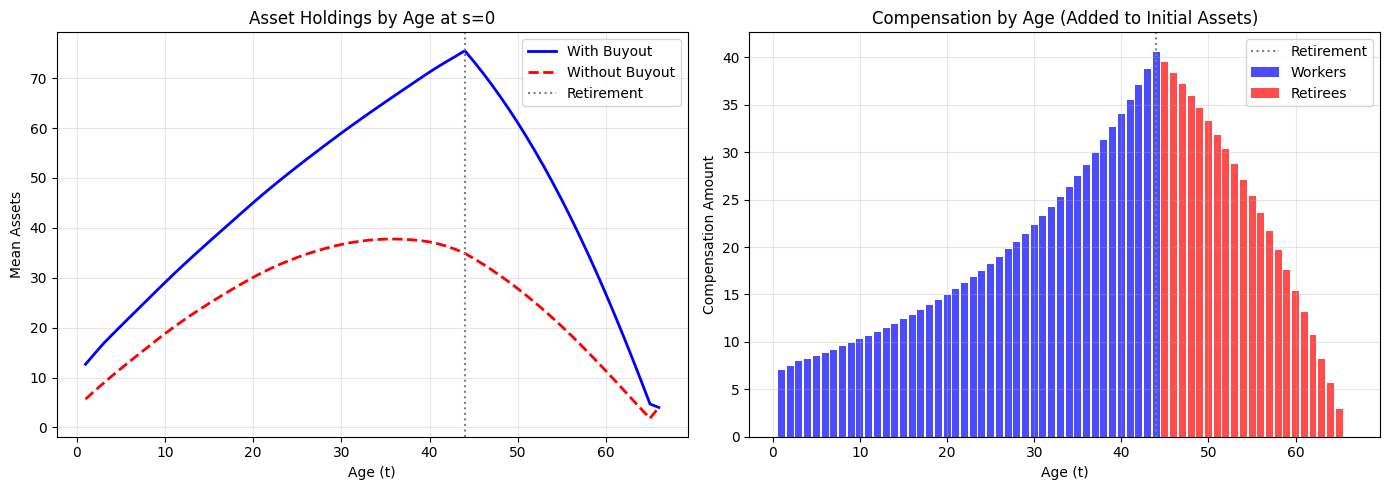

In [39]:
# Extract results
_, μx_seq_bo, μc_seq_bo, k_seq_bo, Gb_seq_bo, _, _ = exp1_exo['results_buyout']
_, μx_seq_nb, μc_seq_nb, k_seq_nb, Gb_seq_nb, _, _ = exp1_exo['results_no_buyout']

# Mean assets by age at time s=0 (with vs without buyout)
μa_bo = μx_seq_bo[0, 1:, 0]  # Assets at s=0 with buyout
μa_nb = μx_seq_nb[0, 1:, 0]  # Assets at s=0 without buyout

# Compensation = difference in initial assets
compensation_by_age = μa_bo - μa_nb

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Asset profiles
ages = np.arange(1, hh.T0 + 2)
axes[0].plot(ages, μa_bo, 'b-', linewidth=2, label='With Buyout')
axes[0].plot(ages, μa_nb, 'r--', linewidth=2, label='Without Buyout')
axes[0].axvline(hh.T1 + 1, color='gray', linestyle=':', label='Retirement')
axes[0].set_xlabel('Age (t)')
axes[0].set_ylabel('Mean Assets')
axes[0].set_title('Asset Holdings by Age at s=0')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compensation histogram
working_ages = ages[ages <= hh.T1 + 1]
retired_ages = ages[ages > hh.T1 + 1]
comp_working = compensation_by_age[:hh.T1 + 1]
comp_retired = compensation_by_age[hh.T1 + 1:]

axes[1].bar(working_ages, comp_working, color='blue', alpha=0.7, label='Workers')
axes[1].bar(retired_ages, comp_retired, color='red', alpha=0.7, label='Retirees')
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].axvline(hh.T1 + 1, color='gray', linestyle=':', label='Retirement')
axes[1].set_xlabel('Age (t)')
axes[1].set_ylabel('Compensation Amount')
axes[1].set_title('Compensation by Age (Added to Initial Assets)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

The right panel shows the compensation amounts by age, distinguishing between workers (blue) and retirees (red):

- **Retirees (ages > T1+1)**: Receive the largest compensation because they have already retired and were expecting to receive social security benefits for the remainder of their lives. The compensation equals the present value of these expected future benefits, which can be substantial for those recently retired.

- **Older Workers (ages approaching T1)**: Receive significant compensation because they have paid into the system throughout their working lives but now face the loss of expected benefits. These cohorts have the least time to adjust their saving behavior.

- **Young Workers (ages near 0)**: Receive minimal or zero compensation. They have contributed little to the old system and have their entire working lives to adjust to the new regime by saving more privately.

- **Middle-aged Workers**: Receive intermediate compensation, reflecting their partial contributions and remaining adjustment time.

The declining compensation profile with age (among retirees) reflects the actuarial calculation: older retirees have fewer remaining years of expected benefits. The vertical line marks the retirement age (T1+1), highlighting the discontinuity between workers and retirees in terms of their relationship to the social security system.

Text(0.5, 1.02, 'Experiment 1: Effect of Compensation on Transition Paths')

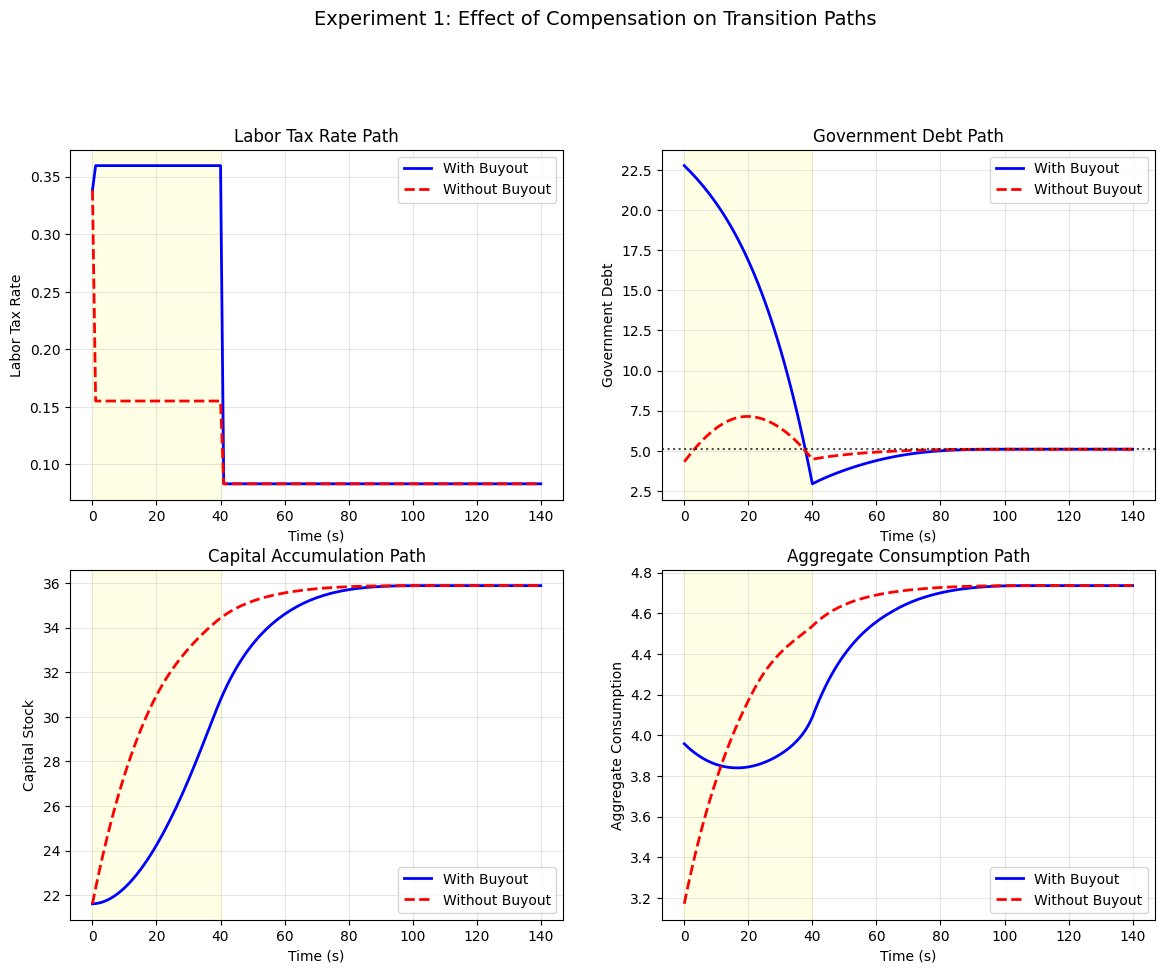

In [40]:
hh = exp1_exo['hh']
tech = exp1_exo['tech']
ss0_exp1 = exp1_exo['ss0']
ss1_exp1 = exp1_exo['ss1']

S_exp1 = Gb_seq_bo.shape[0] - 1
S1_exp1, S2_exp1 = 0, 40

# Construct τ_l sequences
τ_l_seq_bo = np.zeros(S_exp1 + 1)
τ_l_seq_bo[:S1_exp1 + 1] = ss0_exp1.τ_l
τ_l_seq_bo[S1_exp1 + 1:S2_exp1 + 1] = exp1_exo['τ_l_buyout']
τ_l_seq_bo[S2_exp1 + 1:] = ss1_exp1.τ_l

τ_l_seq_nb = np.zeros(S_exp1 + 1)
τ_l_seq_nb[:S1_exp1 + 1] = ss0_exp1.τ_l
τ_l_seq_nb[S1_exp1 + 1:S2_exp1 + 1] = exp1_exo['τ_l_no_buyout']
τ_l_seq_nb[S2_exp1 + 1:] = ss1_exp1.τ_l

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# τ_l comparison
axes[0, 0].plot(τ_l_seq_bo, 'b-', linewidth=2, label='With Buyout')
axes[0, 0].plot(τ_l_seq_nb, 'r--', linewidth=2, label='Without Buyout')
axes[0, 0].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Labor Tax Rate')
axes[0, 0].set_title('Labor Tax Rate Path')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gb comparison
axes[0, 1].plot(Gb_seq_bo, 'b-', linewidth=2, label='With Buyout')
axes[0, 1].plot(Gb_seq_nb, 'r--', linewidth=2, label='Without Buyout')
axes[0, 1].axhline(ss1_exp1.Gb, color='k', linestyle=':', alpha=0.7)
axes[0, 1].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Government Debt')
axes[0, 1].set_title('Government Debt Path')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Capital path
axes[1, 0].plot(k_seq_bo, 'b-', linewidth=2, label='With Buyout')
axes[1, 0].plot(k_seq_nb, 'r--', linewidth=2, label='Without Buyout')
axes[1, 0].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Capital Stock')
axes[1, 0].set_title('Capital Accumulation Path')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Aggregate consumption
c_agg_bo = np.array([np.sum(μc_seq_bo[s] * hh.frac) for s in range(S_exp1 + 1)])
c_agg_nb = np.array([np.sum(μc_seq_nb[s] * hh.frac) for s in range(S_exp1 + 1)])

axes[1, 1].plot(c_agg_bo, 'b-', linewidth=2, label='With Buyout')
axes[1, 1].plot(c_agg_nb, 'r--', linewidth=2, label='Without Buyout')
axes[1, 1].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Aggregate Consumption')
axes[1, 1].set_title('Aggregate Consumption Path')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Experiment 1: Effect of Compensation on Transition Paths', fontsize=14, y=1.02)

The figures above reveal important differences between the two compensation schemes under exogenous prices:

1. **Capital Stock**: The buy-out scheme leads to a slower initial rise in private capital because the government must make large transfers to compensate affected generations. However, both schemes converge to the same terminal steady state.

2. **Government Debt**: The buy-out scheme initially increases debt to finance compensation, but the debt path eventually returns to the target level. Without buy-out, debt adjusts more smoothly.

Text(0.5, 1.02, 'Consumption Paths by Cohort (Experiment 1)')

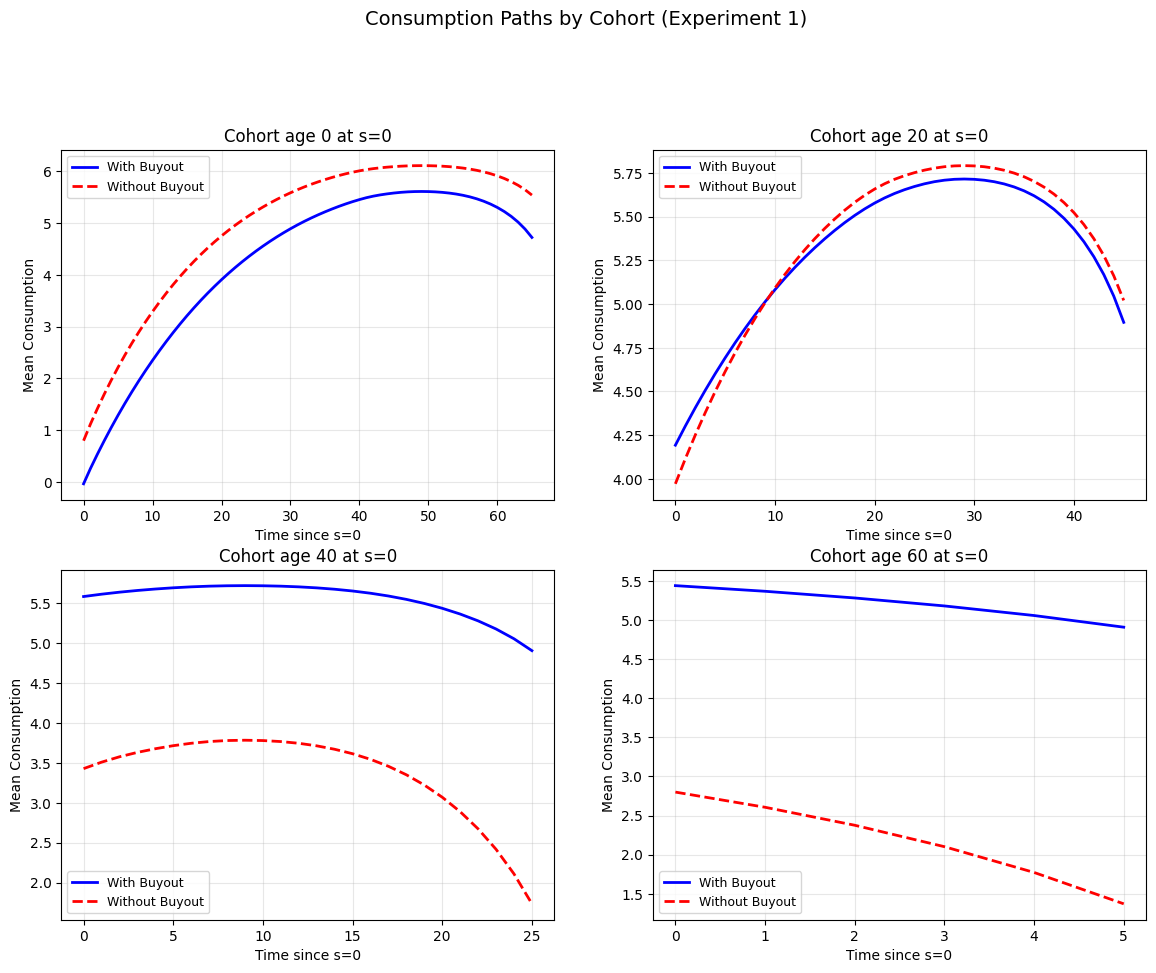

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

selected_ages = [0, 20, 40, 60]  # Cohorts at different ages at s=0

for idx, age_at_0 in enumerate(selected_ages):
    ax = axes[idx // 2, idx % 2]
    
    remaining_life = hh.T0 - age_at_0
    max_time = min(remaining_life + 1, S_exo + 1)
    
    c_bo = [μc_seq_bo[s, age_at_0 + s] for s in range(max_time) if age_at_0 + s <= hh.T0]
    c_nb = [μc_seq_nb[s, age_at_0 + s] for s in range(max_time) if age_at_0 + s <= hh.T0]
    
    ax.plot(c_bo, 'b-', linewidth=2, label='With Buyout')
    ax.plot(c_nb, 'r--', linewidth=2, label='Without Buyout')
    ax.set_xlabel('Time since s=0')
    ax.set_ylabel('Mean Consumption')
    ax.set_title(f'Cohort age {age_at_0} at s=0')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Consumption Paths by Cohort (Experiment 1)', fontsize=14, y=1.02)

The four panels show consumption trajectories for cohorts at different ages when the reform occurs (s=0). Comparing the solid blue line (with buyout) to the dashed red line (without buyout) reveals striking patterns:

- **Cohort age 0 (Young workers)**: The consumption paths are nearly identical with and without buyout. Young workers receive little compensation and have decades to adjust their saving, so the buyout scheme has minimal impact on their consumption.

- **Cohort age 20 (Prime-age workers)**: Small differences emerge. Without buyout, consumption is slightly higher initially but converges. The buyout provides a modest wealth transfer that slightly smooths consumption.

- **Cohort age 40 (Near-retirement workers)**: More noticeable differences appear. With buyout, consumption is higher early in the transition as these workers receive compensation for lost benefits they were close to receiving. Without buyout, they experience a consumption drop as they must adjust to the loss.

- **Cohort age 60 (Retirees)**: The most dramatic difference. With buyout, retirees maintain higher consumption throughout their remaining years because compensation fully replaces their lost social security income. Without buyout, consumption drops sharply as they lose benefits with no ability to make up the difference through additional work or saving.

The key insight is that the buyout scheme successfully protects older generations from consumption losses, while younger generations are largely unaffected regardless of the compensation scheme.

### endogenous price

The endogenous price case is more complex because factor prices (wage $w$ and return $R$) are determined by the capital stock. This creates general equilibrium feedback effects:
- Changes in saving behavior affect capital accumulation
- Capital changes affect marginal products and thus prices
- Price changes feed back into household decisions

The `compute_factor_prices` function computes equilibrium prices from the aggregate capital stock using the Cobb-Douglas production function's first-order conditions.

In [42]:
@jit
def compute_factor_prices(k_prod, ε_bar, A, α, δ):
    """Compute factor prices from Cobb-Douglas."""
    k_per_eff = k_prod / ε_bar
    r = A * α * (k_per_eff ** (α - 1))
    w = A * (1 - α) * (k_per_eff ** α)
    RR = 1 + r - δ
    return r, w, RR

In [43]:
def find_ss_endo(debt2gdp_target, policy_target, hh, tech, RR_init=None, w_init=None,
                 max_iter=50, tol=1e-5, verbose=False):
    """Find steady state with endogenous factor prices."""
    τ_a, τ_0, benef, G = policy_target
    ε_bar = float(jnp.sum(hh.frac * hh.ε_arr))
    
    RR = RR_init if RR_init else tech.RR
    w = w_init if w_init else tech.w
    
    relaxation = 0.3
    
    for iteration in range(max_iter):
        try:
            ss = ss_target_debt2gdp_exo(debt2gdp_target, (τ_a, τ_0, benef, G), (RR, w), hh, tech)
        except ValueError:
            RR = RR * 0.99
            continue
        
        K_eff = ss.k_bar / hh.n + float(hh.frac[0] * hh.x0[0])
        r_new, w_new, RR_new = compute_factor_prices(K_eff, ε_bar, tech.A, tech.α_tilde, tech.δ)
        r_new, w_new, RR_new = float(r_new), float(w_new), float(RR_new)
        price_diff = abs(RR_new - RR) + abs(w_new - w)
        
        if verbose and iteration % 5 == 0:
            print(f"    SS iter {iteration}: RR={RR:.6f}, w={w:.4f}, k_bar={ss.k_bar:.4f}")
        
        if price_diff < tol:
            if verbose:
                print(f"    Converged at iteration {iteration}")
            break
        
        RR = RR + relaxation * (RR_new - RR)
        w = w + relaxation * (w_new - w)
    
    return ss_target_debt2gdp_exo(debt2gdp_target, (τ_a, τ_0, benef, G), (RR, w), hh, tech)


def init_price_seq_interp(S, S1, S3, ss0_RR, ss0_w, ss1_RR, ss1_w):

    s_indices = jnp.arange(S + 2)
    t_frac = jnp.clip((s_indices - S1) / (S3 - S1), 0.0, 1.0)
    
    RR_seq = ss0_RR + t_frac * (ss1_RR - ss0_RR)
    w_seq = ss0_w + t_frac * (ss1_w - ss0_w)
    
    RR_seq = jnp.where(s_indices <= S1, ss0_RR, RR_seq)
    w_seq = jnp.where(s_indices <= S1, ss0_w, w_seq)
    RR_seq = jnp.where(s_indices >= S3, ss1_RR, RR_seq)
    w_seq = jnp.where(s_indices >= S3, ss1_w, w_seq)
    
    return jnp.column_stack([RR_seq, w_seq])


@jit
def _update_prices_from_capital(k_seq, k_bar_ss0, n, frac0_x0, ε_bar, A, α, δ, s_indices_full, ss1_RR, ss1_w, S3):

    k_prev = jnp.concatenate([jnp.array([k_bar_ss0]), k_seq[:-1]])
    K_eff = k_prev / n + frac0_x0
    
    k_per_eff = K_eff / ε_bar
    r_new = A * α * (k_per_eff ** (α - 1))
    w_new = A * (1 - α) * (k_per_eff ** α)
    RR_new = 1 + r_new - δ
    
    price_seq_new = jnp.column_stack([RR_new, w_new])
    price_seq_new = jnp.concatenate([price_seq_new, price_seq_new[-1:]], axis=0)
    
    terminal_prices = jnp.array([[ss1_RR, ss1_w]])
    mask = s_indices_full >= S3
    price_seq_new = jnp.where(mask[:, None], terminal_prices, price_seq_new)
    
    return price_seq_new


def find_transition_endo(price_seq, policy_seq_base,
                         ss0, ss1, hh, tech, S, S1, S2, S3,
                         compensation_data=None,
                         max_iter=50, tol=1e-3,
                         relaxation=0.5, verbose=False):
    """
    Find transition with endogenous prices.
    """
    ε_bar = float(jnp.sum(hh.frac * hh.ε_arr))
    frac0_x0 = float(hh.frac[0] * hh.x0[0])
    
    price_seq = jnp.asarray(price_seq)
    policy_seq_base = jnp.asarray(policy_seq_base)
    
    # Pre-create iteration arrays for price update
    s_indices_full = jnp.arange(S + 2)
    
    if verbose:
        print("  Starting price iteration...")
    
    for iteration in range(max_iter):
        try:
            τ_l_trans, results = find_transition_exo(
                price_seq, policy_seq_base, ss0, ss1,
                hh, tech, S, S1, S2,
                compensation_data=compensation_data
            )
        except ValueError:
            τ_l_trans = 0.35
            results = transition_paths(
                τ_l_trans, price_seq, policy_seq_base,
                ss0, ss1, hh, tech, S, S1, S2,
                ss0.μx_arr, ss0.Σx_arr
            )
        
        _, μx_seq, μc_seq, k_seq, Gb_seq, F_seq, Ao_seq = results
        
        price_seq_new = _update_prices_from_capital(
            k_seq, float(ss0.k_bar), hh.n, float(frac0_x0), float(ε_bar),
            tech.A, tech.α_tilde, tech.δ, s_indices_full, float(ss1.RR), float(ss1.w), S3
        )
        
        price_diff = float(jnp.max(jnp.abs(price_seq_new - price_seq)))
        
        if verbose:
            print(f"  Iter {iteration}: τ_l={τ_l_trans:.4f}, price_diff={price_diff:.6f}")
        
        if price_diff < tol:
            if verbose:
                print(f"  Converged at iteration {iteration}")
            break
        
        price_seq = price_seq + relaxation * (price_seq_new - price_seq)
    
    return τ_l_trans, price_seq, results

In [44]:
# Compute endogenous prices for initial SS
ε_bar = float(jnp.sum(hh.frac * hh.ε_arr))
K_eff_0 = ss0.k_bar / hh.n + float(hh.frac[0] * hh.x0[0])
r0_endo, w0_endo, RR0_endo = compute_factor_prices(K_eff_0, ε_bar, tech.A, tech.α_tilde, tech.δ)
r0_endo, w0_endo, RR0_endo = float(r0_endo), float(w0_endo), float(RR0_endo)

ss0_exp1_endo = SteadyState(
    P_arr=ss0.P_arr, ξ_arr=ss0.ξ_arr, Ao_arr=ss0.Ao_arr, F_arr=ss0.F_arr,
    μx_arr=ss0.μx_arr, μc_arr=ss0.μc_arr, Σx_arr=ss0.Σx_arr, Vc_arr=ss0.Vc_arr,
    debt2gdp=ss0.debt2gdp, τ_l=ss0.τ_l, benef=ss0.benef, Gb=ss0.Gb,
    k_bar=ss0.k_bar, RR=RR0_endo, w=w0_endo, r=r0_endo, k2gdp=ss0.k2gdp
)

ss1_exp1_endo = find_ss_endo(
    ss0.debt2gdp, (τ_a_0, τ_0_0, 0, G_0), hh, tech,
    RR_init=tech.RR, w_init=tech.w, verbose=True
)

    SS iter 0: RR=1.067500, w=5.0147, k_bar=35.8836
    SS iter 5: RR=1.044914, w=5.7382, k_bar=30.4554
    SS iter 10: RR=1.044368, w=5.7345, k_bar=30.1789
    SS iter 15: RR=1.044367, w=5.7305, k_bar=30.1769
    SS iter 20: RR=1.044368, w=5.7298, k_bar=30.1770
    SS iter 25: RR=1.044369, w=5.7296, k_bar=30.1770
    Converged at iteration 28


In [45]:
# Initialize price sequence
price_seq_exp1_endo = init_price_seq_interp(
    S_endo, S1, S3,
    float(ss0_exp1_endo.RR), float(ss0_exp1_endo.w),
    float(ss1_exp1_endo.RR), float(ss1_exp1_endo.w)
)

# Policy sequence
policy_seq_exp1_endo = jnp.empty((S_endo + 2, 6))
policy_seq_exp1_endo = policy_seq_exp1_endo.at[:S1 + 1, 0].set(ss0_exp1_endo.τ_l)
policy_seq_exp1_endo = policy_seq_exp1_endo.at[S2 + 1:, 0].set(ss1_exp1_endo.τ_l)
policy_seq_exp1_endo = policy_seq_exp1_endo.at[:, 1].set(τ_a_0)
policy_seq_exp1_endo = policy_seq_exp1_endo.at[:, 2].set(τ_0_0)
policy_seq_exp1_endo = policy_seq_exp1_endo.at[:, 3].set(0)
policy_seq_exp1_endo = policy_seq_exp1_endo.at[:, 4].set(G_0)
policy_seq_exp1_endo = policy_seq_exp1_endo.at[:, 5].set(ss0_exp1_endo.Gb)

In [46]:
# Buyout compensation
benef_diff_exp1_endo = jnp.zeros(hh.T0 + 1)
benef_diff_exp1_endo = benef_diff_exp1_endo.at[hh.T1 + 1:].set(ss0_exp1_endo.benef - ss1_exp1_endo.benef)

# Solve with price iteration
print("\n  Solving transition with endogenous prices...")
τ_l_exp1_endo_bo, price_seq_exp1_endo_conv, results_exp1_endo = find_transition_endo(
    price_seq_exp1_endo, policy_seq_exp1_endo, ss0_exp1_endo, ss1_exp1_endo,
    hh, tech, S_endo, S1, S2, S3,
    compensation_data=(benef_diff_exp1_endo, ss0_exp1_endo.τ_l), verbose=True
)
_, μx_seq_exp1_endo, μc_seq_exp1_endo, k_seq_exp1_endo, Gb_seq_exp1_endo, _, _ = results_exp1_endo


  Solving transition with endogenous prices...
  Starting price iteration...
  Iter 0: τ_l=0.3392, price_diff=0.490721
  Iter 1: τ_l=0.3551, price_diff=0.185370
  Iter 2: τ_l=0.3639, price_diff=0.064719
  Iter 3: τ_l=0.3678, price_diff=0.021136
  Iter 4: τ_l=0.3694, price_diff=0.007022
  Iter 5: τ_l=0.3701, price_diff=0.002389
  Iter 6: τ_l=0.3703, price_diff=0.000835
  Converged at iteration 6


In [47]:
# Store for later use
exp1_endo = {
    'ss0': ss0_exp1_endo, 'ss1': ss1_exp1_endo,
    'τ_l_buyout': τ_l_exp1_endo_bo,
    'price_seq': price_seq_exp1_endo_conv,
    'k_seq': k_seq_exp1_endo, 'Gb_seq': Gb_seq_exp1_endo,
    'results': results_exp1_endo,
    'μc_seq': μc_seq_exp1_endo, 'μx_seq': μx_seq_exp1_endo
}

Text(0.5, 1.02, 'Experiment 1 (Buyout): Fixed vs Endogenous Factor Prices')

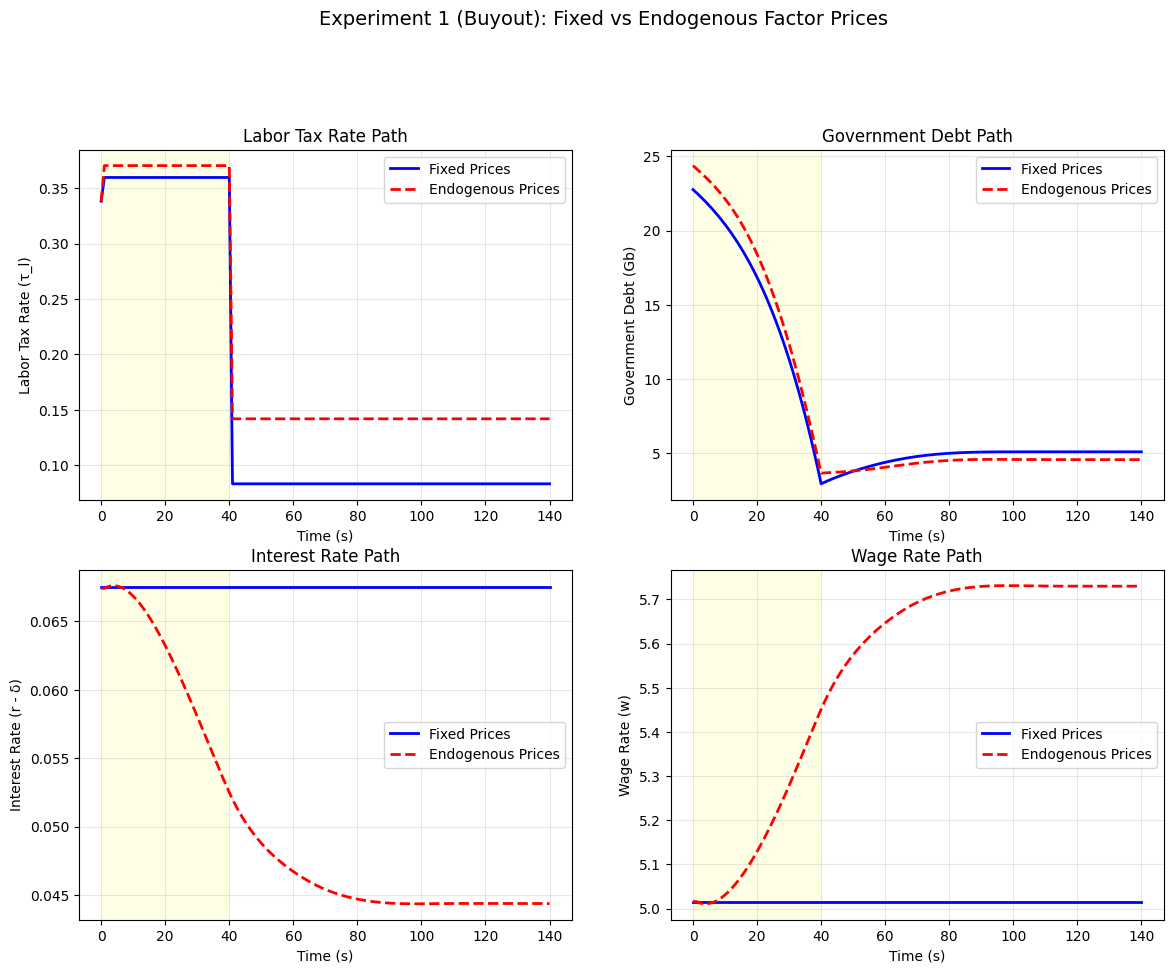

In [48]:
# Get endogenous price sequences
price_seq_endo = exp1_endo['price_seq']
S_endo = price_seq_endo.shape[0] - 2

# Construct fixed price sequences for comparison
RR_fixed = tech.RR
w_fixed = tech.w

# For fixed prices, construct τ_l sequence
τ_l_seq_fixed = np.zeros(S_exp1 + 1)
τ_l_seq_fixed[:S1_exp1 + 1] = ss0_exp1.τ_l
τ_l_seq_fixed[S1_exp1 + 1:S2_exp1 + 1] = exp1_exo['τ_l_buyout']
τ_l_seq_fixed[S2_exp1 + 1:] = ss1_exp1.τ_l

# For endogenous prices
τ_l_seq_endo = np.zeros(S_endo + 1)
τ_l_seq_endo[:S1_exp1 + 1] = exp1_endo['ss0'].τ_l
τ_l_seq_endo[S1_exp1 + 1:S2_exp1 + 1] = exp1_endo['τ_l_buyout']
τ_l_seq_endo[S2_exp1 + 1:] = exp1_endo['ss1'].τ_l

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Labor tax comparison
axes[0, 0].plot(τ_l_seq_fixed, 'b-', linewidth=2, label='Fixed Prices')
axes[0, 0].plot(τ_l_seq_endo[:len(τ_l_seq_fixed)], 'r--', linewidth=2, label='Endogenous Prices')
axes[0, 0].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Labor Tax Rate (τ_l)')
axes[0, 0].set_title('Labor Tax Rate Path')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Government debt comparison
Gb_seq_fixed = Gb_seq_bo
Gb_seq_endo_exp1 = exp1_endo['Gb_seq']
axes[0, 1].plot(Gb_seq_fixed, 'b-', linewidth=2, label='Fixed Prices')
axes[0, 1].plot(Gb_seq_endo_exp1[:len(Gb_seq_fixed)], 'r--', linewidth=2, label='Endogenous Prices')
axes[0, 1].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Government Debt (Gb)')
axes[0, 1].set_title('Government Debt Path')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Interest rate comparison
r_fixed = np.full(S_exp1 + 1, tech.r - tech.δ)
r_endo = price_seq_endo[:-1, 0] - 1  # RR - 1 = r - δ
axes[1, 0].plot(r_fixed, 'b-', linewidth=2, label='Fixed Prices')
axes[1, 0].plot(r_endo[:len(r_fixed)], 'r--', linewidth=2, label='Endogenous Prices')
axes[1, 0].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Interest Rate (r - δ)')
axes[1, 0].set_title('Interest Rate Path')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Wage rate comparison
w_fixed_seq = np.full(S_exp1 + 1, tech.w)
w_endo = price_seq_endo[:-1, 1]
axes[1, 1].plot(w_fixed_seq, 'b-', linewidth=2, label='Fixed Prices')
axes[1, 1].plot(w_endo[:len(w_fixed_seq)], 'r--', linewidth=2, label='Endogenous Prices')
axes[1, 1].axvspan(S1_exp1, S2_exp1, alpha=0.1, color='yellow')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Wage Rate (w)')
axes[1, 1].set_title('Wage Rate Path')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Experiment 1 (Buyout): Fixed vs Endogenous Factor Prices', fontsize=14, y=1.02)

With endogenous prices, the transition dynamics exhibit general equilibrium effects:

1. **Price Dynamics**: As capital accumulates, the return to capital falls while wages rise. This affects saving incentives and the distribution of income across generations.

2. **Amplification Effects**: Price changes amplify some effects relative to the fixed-price case. For example, rising wages benefit workers while falling returns hurt savers.

3. **Convergence**: Despite the additional complexity, the economy still converges to a well-defined terminal steady state with the new price levels.

## Experiment 2

In Experiment 2, the government takes a fundamentally different approach: **social security benefits are maintained**, but the government simultaneously accumulates private capital. This alternative reform:
- **Keeps social security benefits at their original level** (unlike Experiment 1 which eliminates them)
- Finances continued benefits through higher labor taxes during the transition
- Has the government become a net saver, accumulating assets rather than debt
- Targets a large negative debt-to-GDP ratio (government becomes a creditor)

The key insight is that by having the government save on behalf of households, the economy can achieve higher capital accumulation while maintaining the social insurance function of social security. This "government funding" approach contrasts with Experiment 1's "privatization with compensation" approach.

In [49]:
debt2gdp_target_exp2_exo = -1.1785
ss1_exp2_exo = ss_target_debt2gdp_exo(
    debt2gdp_target_exp2_exo,
    (τ_a_0, τ_0_0, benef_0, G_0),
    (RR_exo, w_exo), hh, tech
)

In [50]:
# Price and policy sequences
price_seq_exp2_exo = jnp.column_stack([
    jnp.full(S_exo + 2, RR_exo), 
    jnp.full(S_exo + 2, w_exo)
])

policy_seq_exp2_exo = jnp.empty((S_exo + 2, 6))
policy_seq_exp2_exo = policy_seq_exp2_exo.at[:S1 + 1, 0].set(ss0.τ_l)
policy_seq_exp2_exo = policy_seq_exp2_exo.at[S2 + 1:, 0].set(ss1_exp2_exo.τ_l)
policy_seq_exp2_exo = policy_seq_exp2_exo.at[:, 1].set(τ_a_0)
policy_seq_exp2_exo = policy_seq_exp2_exo.at[:, 2].set(τ_0_0)
policy_seq_exp2_exo = policy_seq_exp2_exo.at[:, 3].set(benef_0)
policy_seq_exp2_exo = policy_seq_exp2_exo.at[:, 4].set(G_0)
policy_seq_exp2_exo = policy_seq_exp2_exo.at[:, 5].set(Gb_0)

# Solve (no compensation)
τ_l_exp2_exo, results_exp2_exo = find_transition_exo(
    price_seq_exp2_exo, policy_seq_exp2_exo, ss0, ss1_exp2_exo,
    hh, tech, S_exo, S1, S2
)

In [51]:
# Store results for later use/plotting
carryover_exp2, μx_seq_exp2_exo, μc_seq_exp2_exo, k_seq_exp2_exo, Gb_seq_exp2_exo, F_seq_exp2_exo, Ao_seq_exp2_exo = results_exp2_exo
exp2_exo = {
    'ss0': ss0, 'ss1': ss1_exp2_exo,
    'τ_l_trans': τ_l_exp2_exo,
    'results': results_exp2_exo,
    'k_seq': k_seq_exp2_exo, 'Gb_seq': Gb_seq_exp2_exo,
    'μc_seq': μc_seq_exp2_exo, 'μx_seq': μx_seq_exp2_exo
}

In [52]:
# Compute endogenous prices for initial SS (reuse from Exp 1)
ss0_exp2_endo = ss0_exp1_endo  # Same initial SS

# Terminal steady state with endogenous prices
ss1_exp2_endo = find_ss_endo(
    debt2gdp_target=-1.925,
    policy_target=(τ_a_0, τ_0_0, benef_0, G_0),
    hh=hh, tech=tech,
    RR_init=tech.RR, w_init=tech.w,
    verbose=True
)

    SS iter 0: RR=1.067500, w=5.0147, k_bar=43.5008
    SS iter 5: RR=1.044208, w=5.7762, k_bar=30.1845
    SS iter 10: RR=1.044343, w=5.7374, k_bar=30.1716
    SS iter 15: RR=1.044370, w=5.7307, k_bar=30.1742
    SS iter 20: RR=1.044373, w=5.7297, k_bar=30.1747
    SS iter 25: RR=1.044373, w=5.7295, k_bar=30.1747
    Converged at iteration 29


In [53]:
# Initialize price sequence
price_seq_exp2_endo = init_price_seq_interp(
    S_endo, S1, S3,
    float(ss0_exp2_endo.RR), float(ss0_exp2_endo.w),
    float(ss1_exp2_endo.RR), float(ss1_exp2_endo.w)
)

# Policy sequence
policy_seq_exp2_endo = jnp.empty((S_endo + 2, 6))
policy_seq_exp2_endo = policy_seq_exp2_endo.at[:S1 + 1, 0].set(ss0_exp2_endo.τ_l)
policy_seq_exp2_endo = policy_seq_exp2_endo.at[S2 + 1:, 0].set(ss1_exp2_endo.τ_l)
policy_seq_exp2_endo = policy_seq_exp2_endo.at[:, 1].set(τ_a_0)
policy_seq_exp2_endo = policy_seq_exp2_endo.at[:, 2].set(τ_0_0)
policy_seq_exp2_endo = policy_seq_exp2_endo.at[:, 3].set(benef_0)
policy_seq_exp2_endo = policy_seq_exp2_endo.at[:, 4].set(G_0)
policy_seq_exp2_endo = policy_seq_exp2_endo.at[:, 5].set(ss0_exp2_endo.Gb)

# Solve with price iteration (no compensation)
τ_l_exp2_endo, price_seq_exp2_endo_conv, results_exp2_endo = find_transition_endo(
    price_seq_exp2_endo, policy_seq_exp2_endo, ss0_exp2_endo, ss1_exp2_endo,
    hh, tech, S_endo, S1, S2, S3,
    verbose=True
)
_, μx_seq_exp2_endo, μc_seq_exp2_endo, k_seq_exp2_endo, Gb_seq_exp2_endo, _, _ = results_exp2_endo

  Starting price iteration...
  Iter 0: τ_l=0.3662, price_diff=0.395730
  Iter 1: τ_l=0.3772, price_diff=0.204790
  Iter 2: τ_l=0.3851, price_diff=0.106145
  Iter 3: τ_l=0.3898, price_diff=0.052236
  Iter 4: τ_l=0.3924, price_diff=0.023931
  Iter 5: τ_l=0.3937, price_diff=0.010221
  Iter 6: τ_l=0.3942, price_diff=0.004112
  Iter 7: τ_l=0.3944, price_diff=0.001576
  Iter 8: τ_l=0.3945, price_diff=0.000586
  Converged at iteration 8


In [54]:
exp2_endo = {
    'ss0': ss0_exp2_endo, 'ss1': ss1_exp2_endo,
    'τ_l_trans': τ_l_exp2_endo,
    'price_seq': price_seq_exp2_endo_conv,
    'k_seq': k_seq_exp2_endo, 'Gb_seq': Gb_seq_exp2_endo,
    'results': results_exp2_endo,
    'μc_seq': μc_seq_exp2_endo, 'μx_seq': μx_seq_exp2_endo
}

Text(0.5, 1.02, 'Comparison of All Four Reform Scenarios')

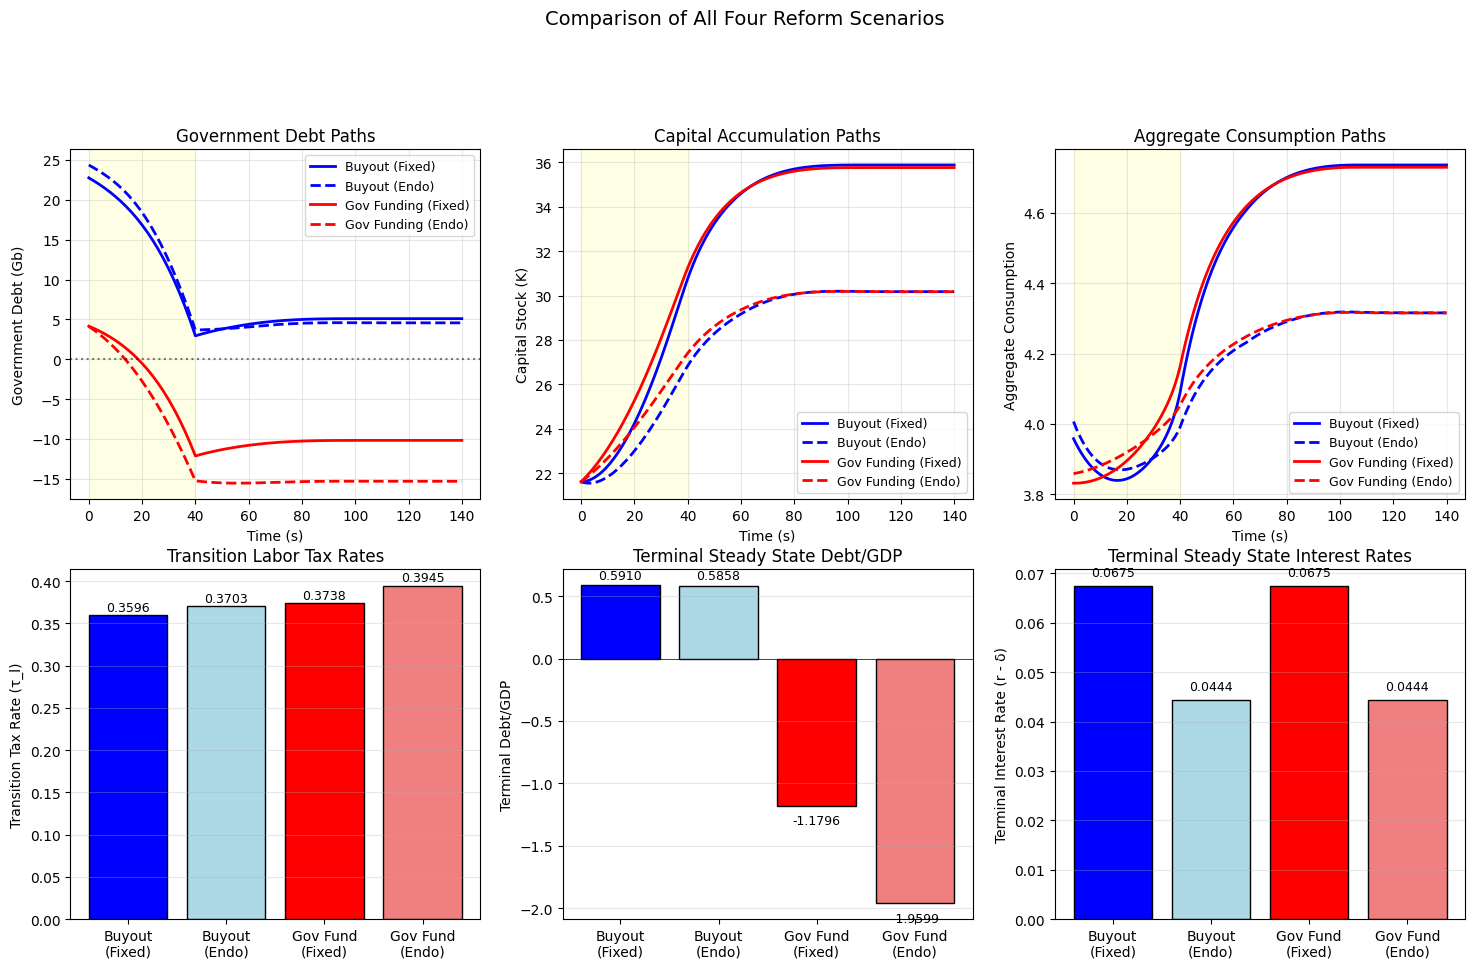

In [55]:
# Get debt sequences for all cases
Gb_buyout_fixed = Gb_seq_bo
Gb_buyout_endo = exp1_endo['Gb_seq']
Gb_accum_fixed = exp2_exo['Gb_seq']
Gb_accum_endo = exp2_endo['Gb_seq']

# Get capital sequences
k_buyout_fixed = k_seq_bo
k_buyout_endo = exp1_endo['k_seq']
k_accum_fixed = exp2_exo['k_seq']
k_accum_endo = exp2_endo['k_seq']

# Common time horizon for plotting
T_plot = min(len(Gb_buyout_fixed), len(Gb_buyout_endo), 
             len(Gb_accum_fixed), len(Gb_accum_endo))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Government Debt paths
axes[0, 0].plot(Gb_buyout_fixed[:T_plot], 'b-', linewidth=2, label='Buyout (Fixed)')
axes[0, 0].plot(Gb_buyout_endo[:T_plot], 'b--', linewidth=2, label='Buyout (Endo)')
axes[0, 0].plot(Gb_accum_fixed[:T_plot], 'r-', linewidth=2, label='Gov Funding (Fixed)')
axes[0, 0].plot(Gb_accum_endo[:T_plot], 'r--', linewidth=2, label='Gov Funding (Endo)')
axes[0, 0].axhline(0, color='k', linestyle=':', alpha=0.5)
axes[0, 0].axvspan(0, 40, alpha=0.1, color='yellow')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Government Debt (Gb)')
axes[0, 0].set_title('Government Debt Paths')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Capital paths
axes[0, 1].plot(k_buyout_fixed[:T_plot], 'b-', linewidth=2, label='Buyout (Fixed)')
axes[0, 1].plot(k_buyout_endo[:T_plot], 'b--', linewidth=2, label='Buyout (Endo)')
axes[0, 1].plot(k_accum_fixed[:T_plot], 'r-', linewidth=2, label='Gov Funding (Fixed)')
axes[0, 1].plot(k_accum_endo[:T_plot], 'r--', linewidth=2, label='Gov Funding (Endo)')
axes[0, 1].axvspan(0, 40, alpha=0.1, color='yellow')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Capital Stock (K)')
axes[0, 1].set_title('Capital Accumulation Paths')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Aggregate consumption (compute for all four cases)
_, μx_exp2_exo, μc_exp2_exo, _, _, _, _ = exp2_exo['results']
_, μx_exp1_endo, μc_exp1_endo, _, _, _, _ = exp1_endo['results']
_, μx_exp2_endo, μc_exp2_endo, _, _, _, _ = exp2_endo['results']

c_agg_buyout_fixed = c_agg_bo[:T_plot]
c_agg_buyout_endo = np.array([np.sum(μc_exp1_endo[s] * hh.frac) for s in range(min(T_plot, μc_exp1_endo.shape[0]))])
c_agg_accum_fixed = np.array([np.sum(μc_exp2_exo[s] * hh.frac) for s in range(min(T_plot, μc_exp2_exo.shape[0]))])
c_agg_accum_endo = np.array([np.sum(μc_exp2_endo[s] * hh.frac) for s in range(min(T_plot, μc_exp2_endo.shape[0]))])

axes[0, 2].plot(c_agg_buyout_fixed[:T_plot], 'b-', linewidth=2, label='Buyout (Fixed)')
axes[0, 2].plot(c_agg_buyout_endo[:T_plot], 'b--', linewidth=2, label='Buyout (Endo)')
axes[0, 2].plot(c_agg_accum_fixed[:T_plot], 'r-', linewidth=2, label='Gov Funding (Fixed)')
axes[0, 2].plot(c_agg_accum_endo[:T_plot], 'r--', linewidth=2, label='Gov Funding (Endo)')
axes[0, 2].axvspan(0, 40, alpha=0.1, color='yellow')
axes[0, 2].set_xlabel('Time (s)')
axes[0, 2].set_ylabel('Aggregate Consumption')
axes[0, 2].set_title('Aggregate Consumption Paths')
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Bar chart: Transition tax rates
cases = ['Buyout\n(Fixed)', 'Buyout\n(Endo)', 'Gov Fund\n(Fixed)', 'Gov Fund\n(Endo)']
τ_l_values = [exp1_exo['τ_l_buyout'], exp1_endo['τ_l_buyout'], 
              exp2_exo['τ_l_trans'], exp2_endo['τ_l_trans']]
colors = ['blue', 'lightblue', 'red', 'lightcoral']
axes[1, 0].bar(cases, τ_l_values, color=colors, edgecolor='black')
axes[1, 0].set_ylabel('Transition Tax Rate (τ_l)')
axes[1, 0].set_title('Transition Labor Tax Rates')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(τ_l_values):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)

# Bar chart: Terminal debt/GDP
debt2gdp_values = [exp1_exo['ss1'].debt2gdp, exp1_endo['ss1'].debt2gdp,
                   exp2_exo['ss1'].debt2gdp, exp2_endo['ss1'].debt2gdp]
axes[1, 1].bar(cases, debt2gdp_values, color=colors, edgecolor='black')
axes[1, 1].axhline(0, color='k', linestyle='-', linewidth=0.5)
axes[1, 1].set_ylabel('Terminal Debt/GDP')
axes[1, 1].set_title('Terminal Steady State Debt/GDP')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(debt2gdp_values):
    axes[1, 1].text(i, v + 0.05 if v > 0 else v - 0.15, f'{v:.4f}', ha='center', fontsize=9)

# Bar chart: Terminal interest rate
r_values = [exp1_exo['ss1'].r - tech.δ, exp1_endo['ss1'].r - tech.δ,
            exp2_exo['ss1'].r - tech.δ, exp2_endo['ss1'].r - tech.δ]
axes[1, 2].bar(cases, r_values, color=colors, edgecolor='black')
axes[1, 2].set_ylabel('Terminal Interest Rate (r - δ)')
axes[1, 2].set_title('Terminal Steady State Interest Rates')
axes[1, 2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r_values):
    axes[1, 2].text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=9)

plt.suptitle('Comparison of All Four Reform Scenarios', fontsize=14, y=1.02)

This comprehensive figure compares the two social security reform experiments under both fixed (solid lines) and endogenous (dashed lines) prices. The scenarios are:
- **Buyout (blue)**: Experiment 1 where social security benefits are eliminated but the government compensates affected generations
- **Government Funding (red)**: Experiment 2 where social security benefits are maintained while the government simultaneously accumulates capital (becoming a net creditor)

**Top Row - Transition Dynamics**:

1. **Government Debt Paths**: The buyout scheme (blue) shows higher debt during transition due to compensation payments, while the government funding scheme (red) leads to negative debt (government asset accumulation). Under endogenous prices (dashed), debt paths adjust more gradually as prices respond to changing capital stocks.

2. **Capital Accumulation Paths**: Both experiments lead to higher long-run capital, but through different mechanisms. The government funding scheme shows faster capital accumulation as public savings supplement private savings. Under endogenous prices, the capital increase moderates returns, which feeds back to reduce the incentive to save.

3. **Aggregate Consumption Paths**: The buyout scheme maintains higher consumption during early transition (compensated generations consume more), while the government funding scheme shows initially lower consumption as resources flow to capital accumulation. Both converge to similar long-run consumption levels.

**Bottom Row - Steady State Comparisons**:

1. **Transition Tax Rates**: Government funding requires higher transition taxes because benefits continue while the government simultaneously accumulates assets. The buyout scheme has lower taxes as benefit payments end immediately.

2. **Terminal Debt/GDP**: Experiment 1 (buyout) targets the initial debt/GDP ratio, while Experiment 2 targets a large negative ratio (government becomes a net creditor).

3. **Terminal Interest Rates**: Under fixed prices, rates are unchanged by construction. Under endogenous prices, the larger capital stock in both experiments reduces the marginal product of capital and hence interest rates.

## 3D surfaces

The 3D surface plots below provide a comprehensive visualization of how assets and consumption evolve over both the age dimension and the calendar time dimension. These plots reveal:

1. **Life-cycle patterns**: The hump-shaped profile of assets over age (saving during working years, dissaving in retirement)
2. **Transition dynamics**: How the reform affects different cohorts at different times
3. **Cohort heterogeneity**: Variation in outcomes across generations who experience the reform at different ages

Each surface represents the joint distribution across age and time, with the z-axis showing the variable of interest (mean assets, asset variance, mean consumption, or consumption variance).

In [56]:
# Compute variances for 3D plotting
def compute_variances(results, ss0, hh):
    """Compute variance sequences from transition results."""
    _, μx_seq, μc_seq, k_seq, Gb_seq, F_seq, Ao_seq = results
    
    # Convert to numpy
    μx_seq = np.array(μx_seq)
    μc_seq_full = np.array(μc_seq)
    F_seq = np.array(F_seq)
    Ao_seq = np.array(Ao_seq)
    Σx_arr_ss0 = np.array(ss0.Σx_arr)
    Σ0 = np.array(hh.Σ0)
    C = np.array(hh.C)
    
    # Get actual dimensions from data
    S_plus_1 = Ao_seq.shape[0]  # S+1
    T0_plus_1 = Ao_seq.shape[1]  # T0+1
    
    Σx_seq = np.empty((S_plus_1 + 1, T0_plus_1 + 1, hh.n_x, hh.n_x))
    Vc_seq = np.empty((S_plus_1, T0_plus_1))
    Va_seq = np.empty((S_plus_1, T0_plus_1))
    
    Σx_seq[:, 0] = Σ0
    Σx_seq[0, :] = Σx_arr_ss0[:T0_plus_1 + 1]
    
    for s in range(S_plus_1):
        for t in range(T0_plus_1):
            Σx_seq[s + 1, t + 1] = C @ C.T + Ao_seq[s, t] @ Σx_seq[s, t] @ Ao_seq[s, t].T
            Vc_seq[s, t] = F_seq[s, t] @ Σx_seq[s, t] @ F_seq[s, t].T
            Va_seq[s, t] = Σx_seq[s, t, 0, 0]
    
    # Extract mean assets - match dimensions with Ao_seq
    μa_seq = μx_seq[:S_plus_1, :T0_plus_1, 0]
    μc_seq_out = μc_seq_full[:S_plus_1, :T0_plus_1]
    
    return μa_seq, Va_seq, μc_seq_out, Vc_seq

# Compute variances for each case
μa_bf, Va_bf, μc_bf, Vc_bf = compute_variances(exp1_exo['results_buyout'], exp1_exo['ss0'], hh)
μa_be, Va_be, μc_be, Vc_be = compute_variances(exp1_endo['results'], exp1_endo['ss0'], hh)
μa_af, Va_af, μc_af, Vc_af = compute_variances(exp2_exo['results'], exp2_exo['ss0'], hh)
μa_ae, Va_ae, μc_ae, Vc_ae = compute_variances(exp2_endo['results'], exp2_endo['ss0'], hh)

case_names = ['Buyout (Fixed)', 'Buyout (Endo)', 'Gov Funding (Fixed)', 'Gov Funding (Endo)']

**Mean Asset by Age and Time**: The following surface will show how asset holdings evolve during the transition. Look for:
- The initial steady state (front edge) showing the pre-reform life-cycle profile
- How the profile shifts as households adjust to the new policy regime
- How peak assets shift as working generations save more to compensate for lost social security benefits

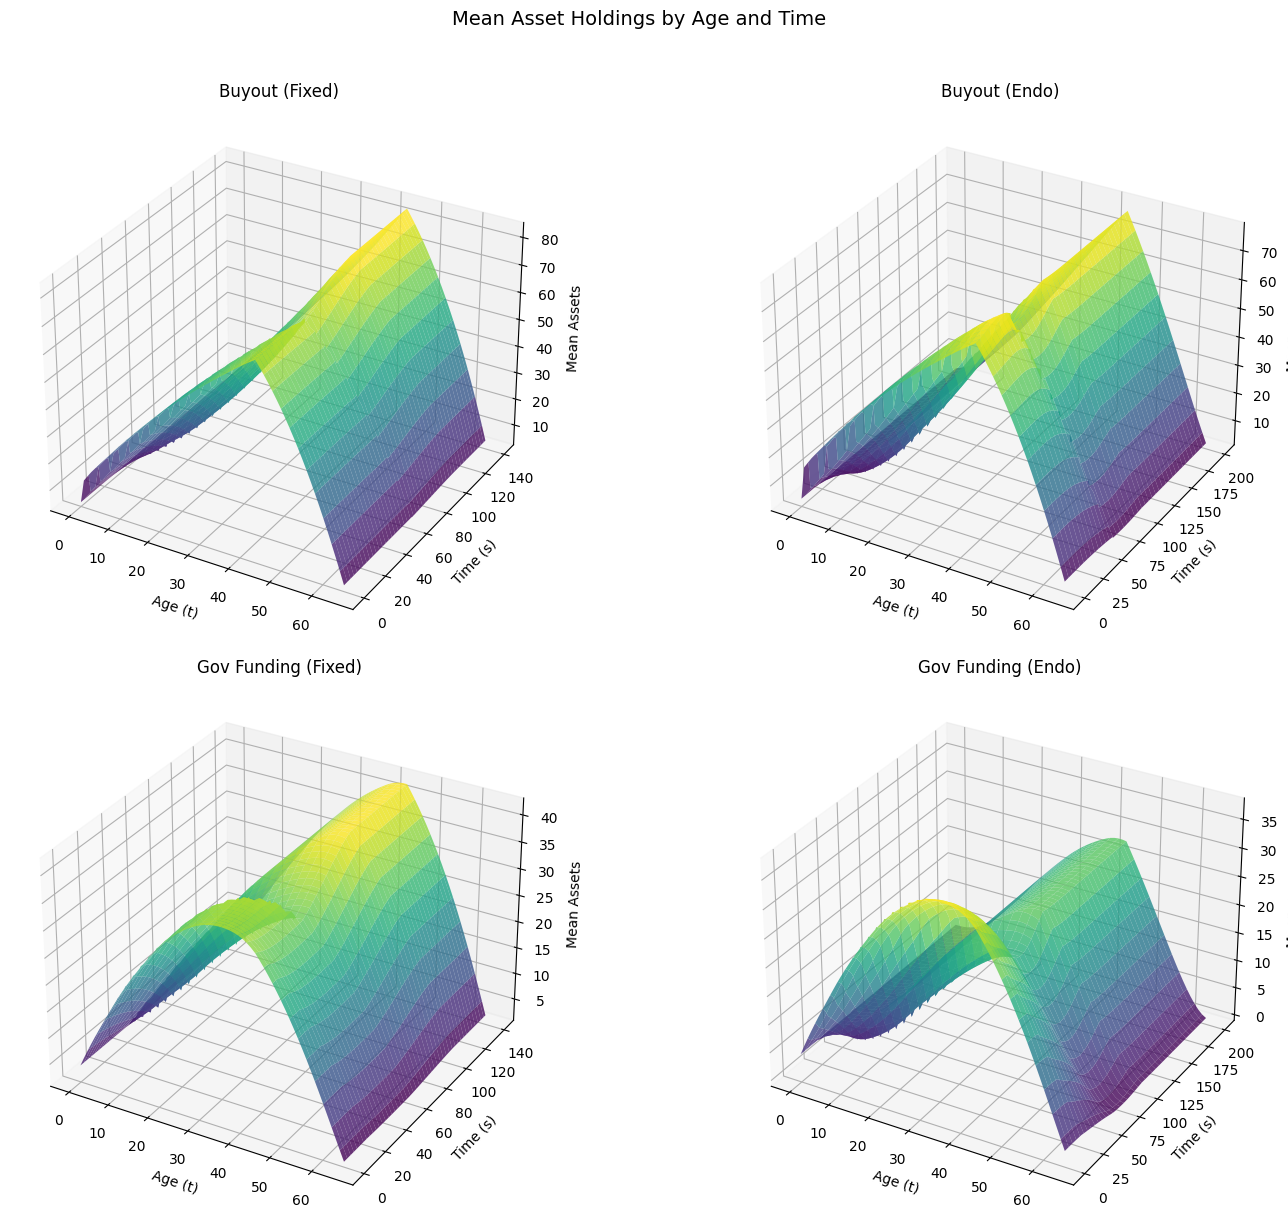

In [57]:
fig = plt.figure(figsize=(16, 12))
μa_cases = [μa_bf, μa_be, μa_af, μa_ae]

for i, (μa, name) in enumerate(zip(μa_cases, case_names)):
    n_time, n_age = μa.shape
    x = np.arange(n_age)
    y = np.arange(n_time)
    X, Y = np.meshgrid(x, y)
    
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    surf = ax.plot_surface(X, Y, μa, cmap='viridis', edgecolor='none', alpha=0.8)
    ax.set_xlabel('Age (t)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Mean Assets')
    ax.set_title(name)

plt.suptitle('Mean Asset Holdings by Age and Time', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Asset Variance by Age and Time**: The next surface shows the dispersion of asset holdings within each age group. Key patterns to observe:
- Variance typically increases with age due to cumulative income shocks
- The reform may affect variance patterns as different cohorts face different policy environments

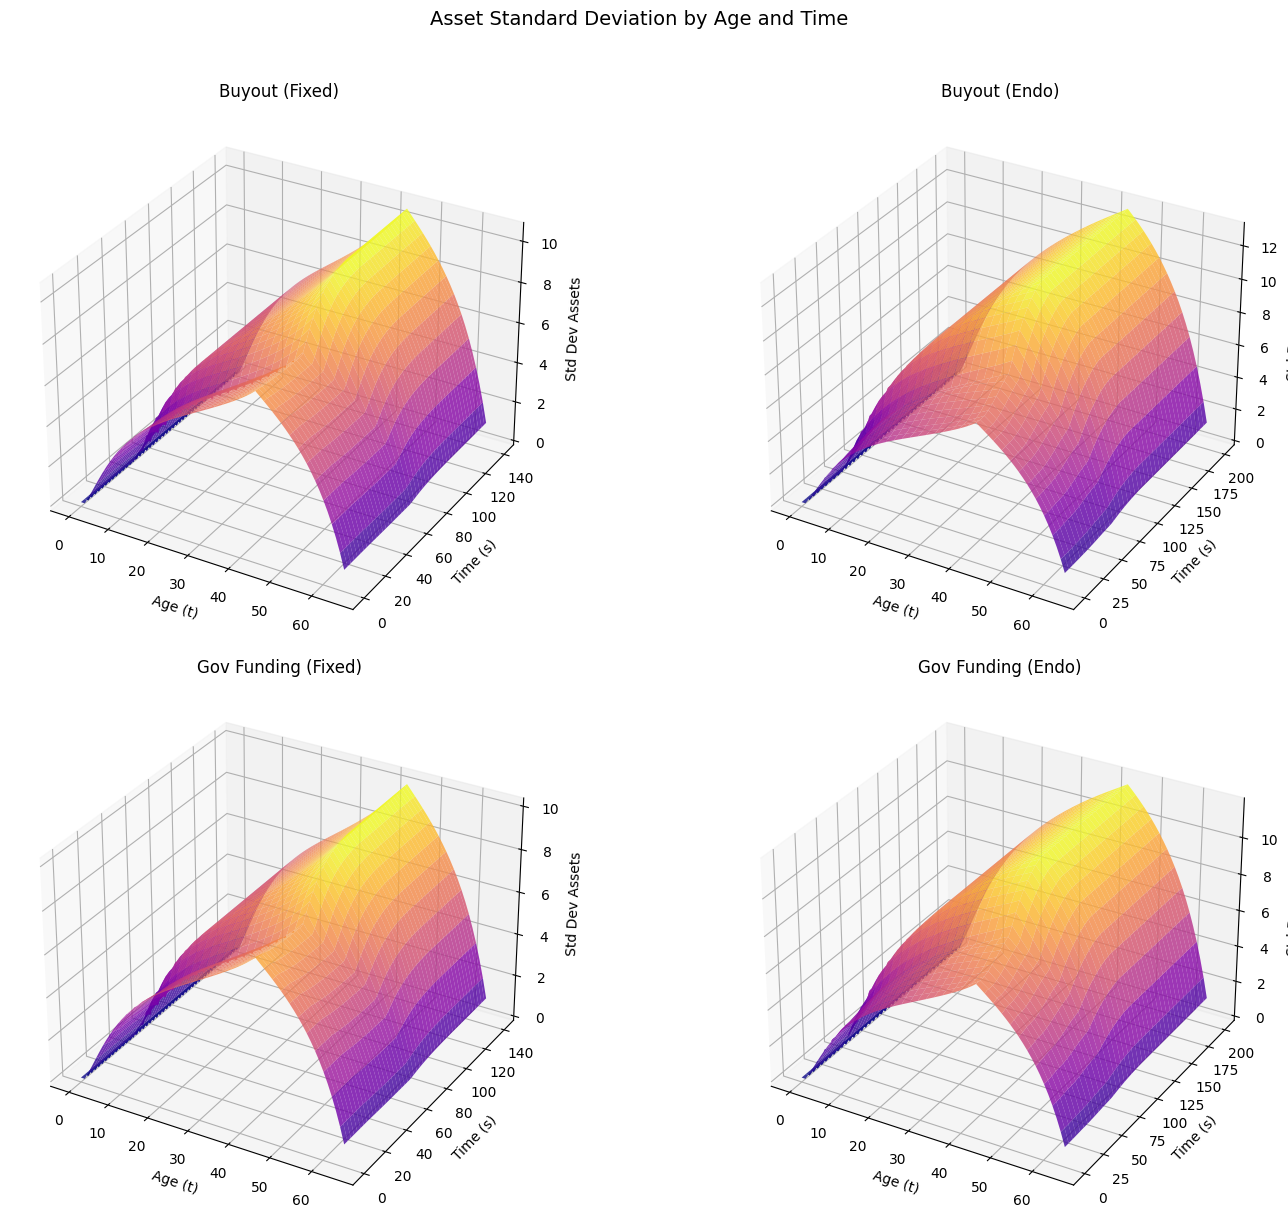

In [58]:
fig = plt.figure(figsize=(16, 12))
Va_cases = [Va_bf, Va_be, Va_af, Va_ae]

for i, (Va, name) in enumerate(zip(Va_cases, case_names)):
    n_time, n_age = Va.shape
    x = np.arange(n_age)
    y = np.arange(n_time)
    X, Y = np.meshgrid(x, y)
    
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    surf = ax.plot_surface(X, Y, np.sqrt(Va), cmap='plasma', edgecolor='none', alpha=0.8)
    ax.set_xlabel('Age (t)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Std Dev Assets')
    ax.set_title(name)

plt.suptitle('Asset Standard Deviation by Age and Time', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Mean Consumption by Age and Time**: The consumption surface will reveal how the reform affects living standards. The optimal consumption path should be smooth across ages (consumption smoothing), but watch for transitional differences as generations adjust their saving behavior.

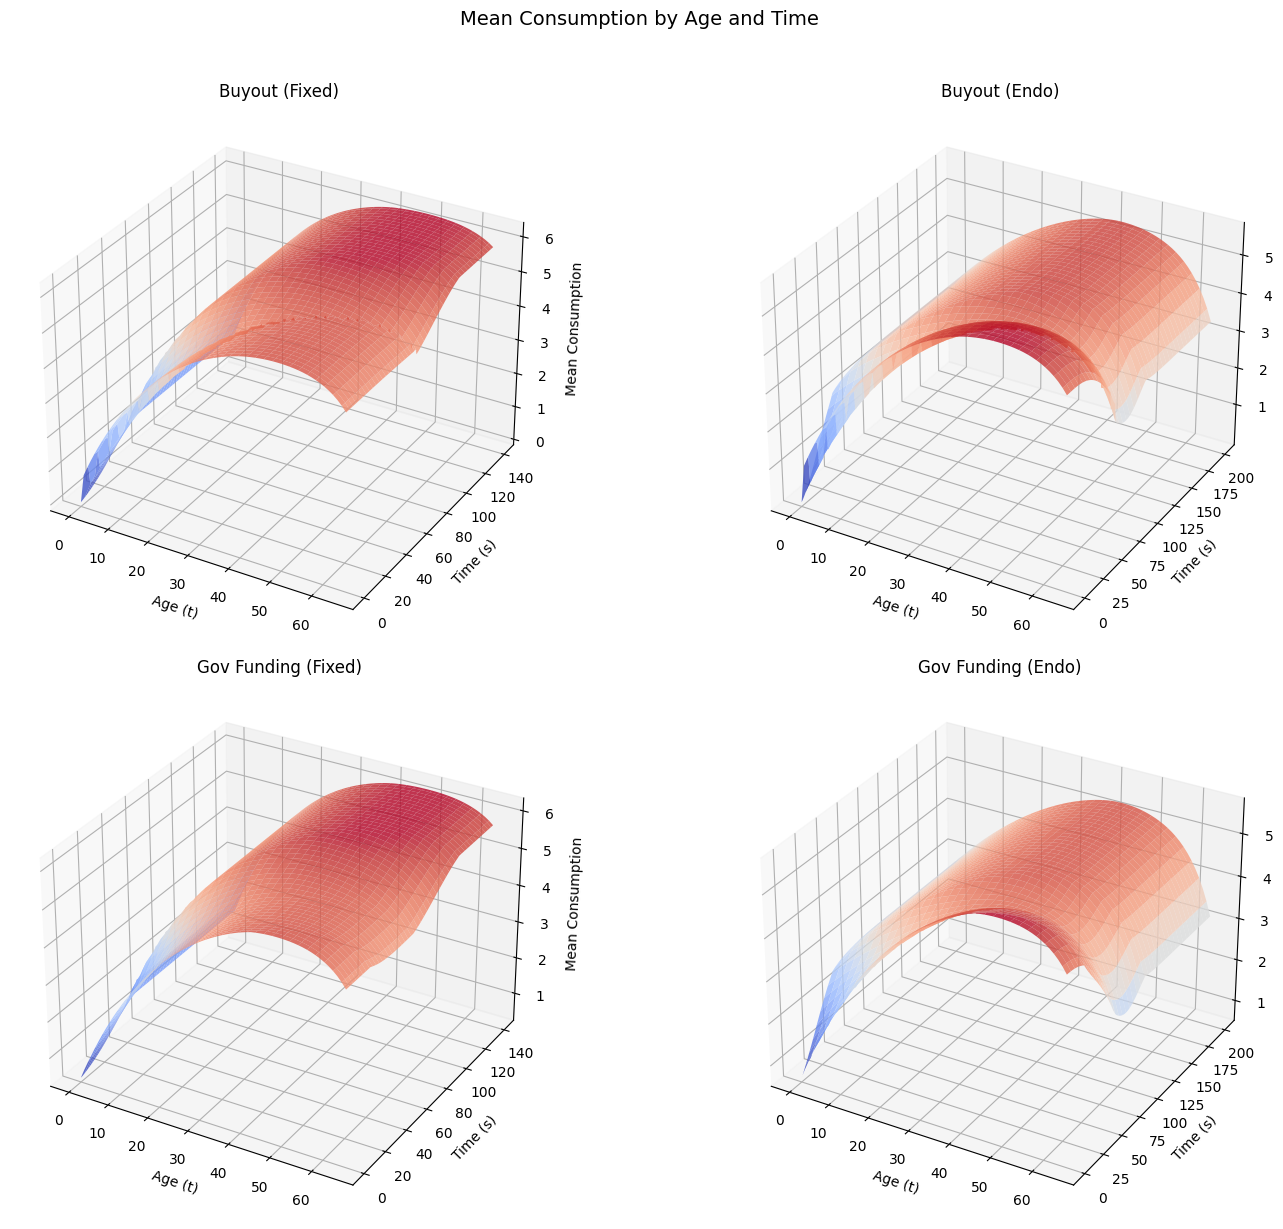

In [59]:
fig = plt.figure(figsize=(16, 12))
μc_cases = [μc_bf, μc_be, μc_af, μc_ae]

for i, (μc, name) in enumerate(zip(μc_cases, case_names)):
    n_time, n_age = μc.shape
    x = np.arange(n_age)
    y = np.arange(n_time)
    X, Y = np.meshgrid(x, y)
    
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    surf = ax.plot_surface(X, Y, μc, cmap='coolwarm', edgecolor='none', alpha=0.8)
    ax.set_xlabel('Age (t)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Mean Consumption')
    ax.set_title(name)

plt.suptitle('Mean Consumption by Age and Time', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Consumption Variance by Age and Time**: This final surface shows consumption inequality within age groups. The LQ framework with its certainty equivalence implies that consumption variance is determined by the underlying income and asset variance.

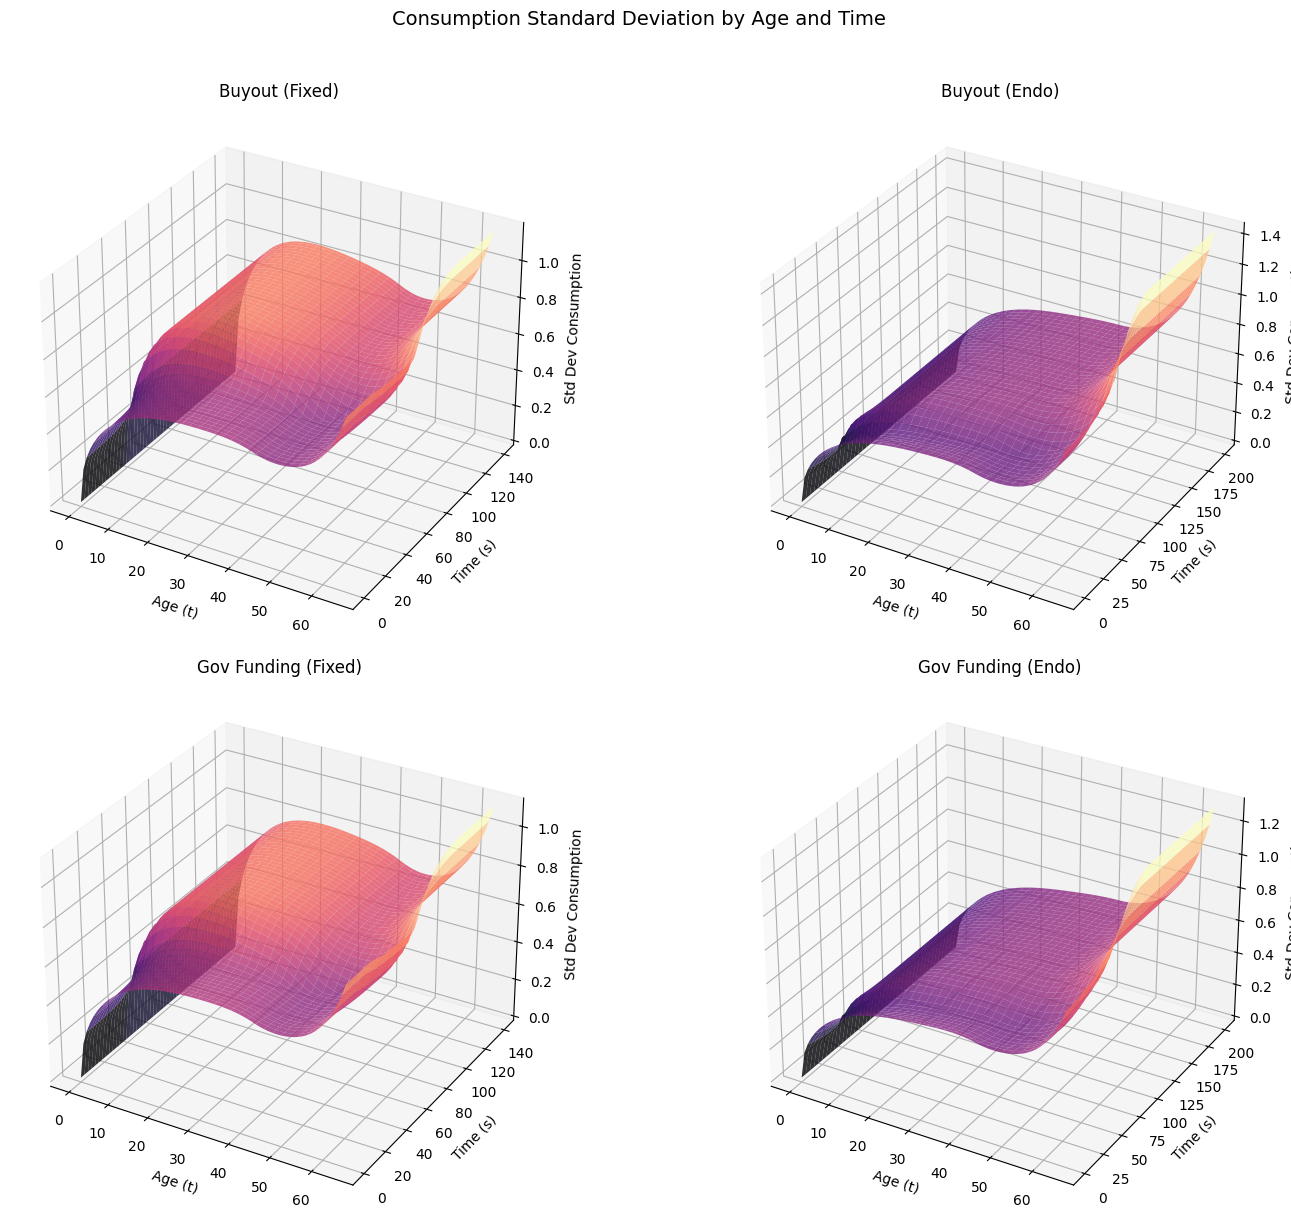

In [60]:
fig = plt.figure(figsize=(16, 12))
Vc_cases = [Vc_bf, Vc_be, Vc_af, Vc_ae]

for i, (Vc, name) in enumerate(zip(Vc_cases, case_names)):
    n_time, n_age = Vc.shape
    x = np.arange(n_age)
    y = np.arange(n_time)
    X, Y = np.meshgrid(x, y)
    
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    surf = ax.plot_surface(X, Y, np.sqrt(Vc), cmap='magma', edgecolor='none', alpha=0.8)
    ax.set_xlabel('Age (t)')
    ax.set_ylabel('Time (s)')
    ax.set_zlabel('Std Dev Consumption')
    ax.set_title(name)

plt.suptitle('Consumption Standard Deviation by Age and Time', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()